In [1]:
from bh_functions import *
import math

Using TensorFlow backend.
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\luluw\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Imported successfully


# Settings of Surrogate model

In [2]:
# Set the ABM Evaluation Budget
budget = 2500

# Set initial evaluated set size, batch size and training pool size
#ini_size = int(budget/2)
ini_size = int(budget/2)
batch = 50
pool_size = budget*batch

# Set out-of-sample test and montecarlo sizes
test_size = 1000
montecarlos = 10

# Get an on out-of-sample test set that does not have combinations from the
# batch or iterative experiments
final_test_size = (test_size * montecarlos)

# Set the ABM parameters and support
bh_exploration_range = np.array([(-2.0, 2.0), # trend_2
                                 (-2.0, 2.0), # trend_1
                                 (0.0, 10.0), # switching_parameter
                                 (0.0, 100.0),# alpha 
                                 (-2.0, 2.0), # bias_2 
                                 (0.0, 1.0),  # weight_past_profits
                                 (-2.0, 2.0), # bias_1
                                 (0.0, 5.0),  # rational_expectation_cost
                                 (1.01, 1.1)])# risk_free_return

In [3]:
# -----
# method:  
#    method and active learning goal
method = "regression"  # "regression", "classification"

# -----
# threshold:  
#    threshold for a real valued y to be considered as a postive prediction
threshold = 0

# -----
# model:
model = "ANN"   # "Gradient boost", "XGBoost" and "ANN" 

# Generate X train and X test, evaluate X test labels

In [4]:
param_dims = bh_exploration_range.shape[0]
print("There is {} parameters in BH model.".format(param_dims))

# Generate Sobol samples for training set
n_dimensions = bh_exploration_range.shape[0]

load_data = False

if load_data == False:
    # Build X_train_pool
    X_train_pool = get_sobol_samples(n_dimensions, pool_size, bh_exploration_range)

    # Build X_test
    X_test = get_sobol_samples(n_dimensions, final_test_size*batch, bh_exploration_range)  # Building a 
                                                    # bigger pool to draw from to avoid overlapping with X_train_pool
    
    '''
    selections = []
    for i, v in enumerate(X_test):   # to avoid overlapping of choices
        if (v not in X_train_pool):
            selections.append(i)
    X_test = unique_rows(X_test[selections])[:final_test_size]   # Final size of X_test is final_test_size
    '''
    np.random.shuffle(X_test)    # shuffle it first
    X_test = X_test[:final_test_size,:]

    # Evaluate the test set for the ABM response
    y_test = evaluate_bh_on_set(X_test, method, threshold)  

    # Output data as a csv
    pd.DataFrame(X_train_pool).to_csv("budget_" + str(budget) + "_X_train_pool.csv")
    pd.DataFrame(X_test).to_csv("budget_" + str(budget) +"_X_test.csv")
    pd.DataFrame(y_test).to_csv("budget_" + str(budget) +"_y_test.csv")
else:
    X_train_pool = pd.read_csv("budget_" + str(budget) + "_X_train_pool.csv").values[:,1:]
    X_test = pd.read_csv("budget_" + str(budget) + "_X_test.csv").values[:,1:]
    y_test = pd.read_csv("budget_" + str(budget) + "_y_test.csv").values[:,-1]

There is 9 parameters in BH model.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [5]:
print_y_test_info(y_test, method, threshold)

There are 1163 out of 10000 in the y test set greater than 0.


# Generate default X,y train for non-active learning

In [6]:
# Build train data without active learning
np.random.shuffle(X_train_pool)    # shuffle it first
default_X_train = X_train_pool[:budget,:]  
default_y_train = evaluate_bh_on_set(default_X_train, method, threshold)

In [7]:
print_evaluated_set_y_info(default_y_train,method, threshold)

There are 316 out of 2500 in the evaluated y set that are greater than 0.


# Generate first X evaluated batch and respective label for active learning

In [8]:
# Build first X evaluated batch with size ini_size
np.random.shuffle(X_train_pool)   # shuffle it first
ini_evaluated_set_X = X_train_pool[:ini_size,:]
unevaluated_set_X = X_train_pool[ini_size:,:]

# Evaluate the train set for the ABM response
ini_evaluated_set_y = evaluate_bh_on_set(ini_evaluated_set_X, method, threshold)

In [9]:
print(X_train_pool.shape)

(125000, 9)


In [10]:
print_evaluated_set_y_info(ini_evaluated_set_y, method, threshold)

There are 131 out of 1250 in the evaluated y set that are greater than 0.


# Experimentation

In this section, I will explore few classification options and compare their performaces. The options are as follows:

### 1. Gradient boost with optimal hyperparameters each round chosen by gridsearch
#### a. With active learning
#### b. No active learning
### 2. XG boost with optimal hyperparameters each round chosen by gridsearch
#### a. With active learning
#### b. No active learning
### 3. ANN with fixed topology 
#### a. With active learning
#### b. No active learning
### 4. Bench mark: gaussian process classification with no active learning

# Gradient Boost

In [11]:
model = "Gradient boost"

## Gradient Boost Active learning:

In [12]:
gb_X_train, gb_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)

--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.
Surrogate model predicted 123726 positive labels out of 123750: 
Parameters bundles of indices:  [107459 101406  97034  74682   3673  97752  29238  43236  80062  96288
  47669  83365  18903 107934  26578  56406  86156  69002  15147  82107
 112491  43720  50215  22341  75860   7325  71343  83785  80399   8132
  27852  87863  35035  79795  80155  77913  67581  44886  35543   6671
  27703  88509  86349   7961  23609  19501  60378  82541 118113   3645]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123423 positive labels out of 123700: 
Parameters bundles of indices:  [104940   6919  21814 103124  62739  24663  20849  73756 120849   5160
  96700   9602  88465  33258 112537  69968  90645  46353  59385  57686
 107107  69975 110478  11878  22491  66207  87853  81971  41129  31002
  91073  53243  56865  44606 122840  12956 105224  78987  45405 114356
  48273 106311 102720  36621  61272  15524 100053  83333  14448  91017]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 111313 positive labels out of 123650: 
Parameters bundles of indices:  [ 46904 103650  15615  85400  62351  46423 120497  70222  11568  83454
  12853  76002  54611  86514 120091  93572  64000  29498  79591  98042
 109151  88197  63330  63433  62369  76880 107428  31874  56451  58031
  24484   6843  32759  45785  62397 106697 105530  52662  13824  24248
  10043  35740 111147  30632 111812  24917  69543   7259 117984  73735]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 120505 positive labels out of 123600: 
Parameters bundles of indices:  [ 13596  81598  54124 111626 106834  81912  28997  63407  92081 112626
 111658  85135  28822  11814  13122  66220  61876 102207  47528  88031
  33711  82369 123074  31831  30263   4831 107422  17428  22520  85854
  87192  82699  17592  97536  22130  93348  28925  94537  77964  95074
  84469  16036 103532   3840  67854  38909  84512 103572  55134  20104]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1050 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 107862 positive labels out of 123550: 
Parameters bundles of indices:  [  3614 122755  10660  66682  93177  20472  40944 113505  16885  96173
 107545  33528  62346  13138  51674  98742  83790  61795  47899  57539
  15693   5416  71198  86380 100640  16230  53195  56286  73729   8288
 112136   8154 111558  69843  64161   4293  44455  30581 119029  50560
  90133  25827   6666  96582  70662  64445  29031  49388  37338 104947]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123481 positive labels out of 123500: 
Parameters bundles of indices:  [ 89694  80678  81240  44927   2104  17790  94148  68801  81251  62996
  33954  26576  75139  85523  85548  69181  74239  66378  64353  80571
 105212  39236  15167  71830  60633 112888 109844  91477  81572  63695
 104824  94193   5514    275  26678  72909 108493  77543  40600  82038
 114112 107771  80433  29421  83393  41826  39220 105937  90923 115484]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 950 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123423 positive labels out of 123450: 
Parameters bundles of indices:  [104734   6911  21773 102923  62616  24614  20809  73610 120600   5156
  96510   9588  88289  33200 112316  69829  90465  46263  59273  57575
 106898  69836 110260  11855  22448  66077  87679  81813  41053  30946
  90892  53142  56755  44521 122591  12932 105016  78834  45318 114127
  48181 106102 102519  36553  61151  15496  99856  83171  14420  90836]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 900 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123362 positive labels out of 123400: 
Parameters bundles of indices:  [ 15346  67436  77116  75179  82494  33266  36854  38013 118727  43346
  13674   1884  89067  84448   1355  70719  76380  52562 112158  65832
  75374  35127  69457  13660 117076  91392  69255   9494  17688  18549
  48830  50214 107686  30875  84848  16138 120772  67679  90209 100787
  28198   3566  31737  87827  61751  40759  82719  40098 117118 119064]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 850 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123327 positive labels out of 123350: 
Parameters bundles of indices:  [ 64768  18110  40042  68592  23612  38353  72024  43114  75853  76689
 107536  46470  15766 100725  44838  56338  12281  93776 112081  41362
  58764  17637 108887 114536 102245  28325  97573 121690  64925   7225
  79140  57449  51498  95321  64684  37581  19636  31674  12168 121374
  36045  52519  90227  70822  80313 109776  43393  40176  98266   5210]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123279 positive labels out of 123300: 
Parameters bundles of indices:  [ 76225  96436  28663  16627  68196  19306  44694  10340  14892  72987
  50842  94875  94676 114704 122625 101573 108702  92700  33293 116713
  11796  63109  52018  62731  58860  62104  13071  48164  47955  72592
 118704 105444  31000 116795    676  20173 120085 112319  46930 113889
  83511  14830  13309  11832  80499  42563 119834  98489  21539  32803]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 750 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 109330 positive labels out of 123250: 
Parameters bundles of indices:  [101730  96417 122689 103080  57997 112296  20745  12271  58503  54152
  13574 113929  22969  12663  73810  34134  68105  82383 116999  73093
 115037  90005  73672 122455   7949  52207  73697  63101  94042  45613
 121753  94032 112370 101852  76775   6657  19440  88271  50037  45298
  52399 108964  24633  36771  91008  15572  86746  63530 104335  60911]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 700 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 119963 positive labels out of 123200: 
Parameters bundles of indices:  [ 63685  66949  75204  43218  29002  48066 101280  20135  73000   2125
 103200  45890  60804 115039  74896  48138 109375  98569  92546  75505
  16234  24793    354  90167  49862 106441 118027   8102  41864  30122
  84356  26126  53268  67911  55695 100724  53162  11754  92298  83479
  76431  37612  69035  28191 121709 107901  81917  26545  33851  11629]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 650 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 85501 positive labels out of 123150: 
Parameters bundles of indices:  [ 95115  51496  85462  15302  35946  54911  19154  72257 120648  14359
 100449  31198  75168  92863  44187  21396  17713  56832   8339 113184
   9765  79064    427 106237  42861  30258  75776  54335  34260 106338
  75925 103078  13827  50700  16937  34654   8308  70895 122216  68585
   9292  31621  57989 104179  81743  10699  77847 102734  24953 115744]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 107089 positive labels out of 123100: 
Parameters bundles of indices:  [ 19741  35004  58868  98581  53559   8581 110752  56316  21207  87634
 113069  56611 102496  82635 104966 120501 108196 108830  15767  57981
  52048  53315 116836 117813  63606  51646 121135  49767  59298  33312
 116374  89640  54989  30709  86557  92824  96604   5655 116107  26726
  47254 116941 112265  80426 115036  26088  39140 101576  76210  40282]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 550 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 118811 positive labels out of 123050: 
Parameters bundles of indices:  [ 68647  37400   9598  93397 112168  35871 122384 107495  34713  66915
  78107  90972   8266   5404  76203    130  66005 106321 119808 104684
  33978 116017 110812  91677 116278 104637 116062  61406  16457  35959
  59405 101357  93665  55572  41931  34606  36875 113078  64916  15003
  95398  43858  81465  29187  51655  14925   7478 118536   4640  77530]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 500 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 103650 positive labels out of 123000: 
Parameters bundles of indices:  [  8201  12534  33160 105287  37452 116231  33864  34858  23362 104837
  65985  90666  93815  21231  56906  37315  74195  77817  35484  81980
 109165 112790  14542 118412  70914  45976  89209  59782  38043  66942
  92570 106436  79581  87466 121970   4867   4657    611  56308 103435
  86092  90002  55419  34446  91558  53104  62854  11518 103688  72895]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 72024 positive labels out of 122950: 
Parameters bundles of indices:  [ 63715  99887  42316  80655 106202  40177 115754   4942  85561  60200
  92988  60997 122325 120238  40513  20648  33847  91064  96108   2613
 119941    219  64246 104008 107527  51804 104085  12435  24722  26195
  92687   6053  63001 104628  97761  63516  12101   2265  46791  98005
  67018 105827  52339  51231  65837 116237  92084  29732  23844  68795]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 107062 positive labels out of 122900: 
Parameters bundles of indices:  [  4493  64590 110645  85768   2290  74299  97181  76287  86035   7745
  86367  21568   1243 119959  19234  20587 119951  34975 105890 121503
 108059  24240  11533  59118  92855 117465  13554  92219  61881 113124
  50022  26604   8735  93320 110585   5018  89321    402  26087  70259
  19834  36826  92292  31559  89966  17017  86534  97422  66475   4200]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 350 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 119291 positive labels out of 122850: 
Parameters bundles of indices:  [ 25687 102301 119814   8260  74406  29522  59278  57805  68616  51202
  92062  78601  12683   8412 108866  16705  24652  11996  48853  57707
  71270  12018  71261  37189  44789  87626  44005  93387  98955  73848
  94448  70737  27577   2564  51783 112838 112523 100703  32174  26962
  38608 114028  25259   7199  74397 113263  56132  81867   3819   2231]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 117892 positive labels out of 122800: 
Parameters bundles of indices:  [120234  67561  57593   7925  76316  44271  63445 114982  22647  27155
 107960  94171   9709  42095  19464  26963  56906 103333   1648  98058
 110897  93723  40729   6367 116525  79729 113532  91487 108980   6288
 111286  55618 106588 119684  25022  44353  49039   3801  34542  56669
  57606  25797  94827  99407  38441  16459  36570  25197  78761  98895]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 122720 positive labels out of 122750: 
Parameters bundles of indices:  [110982  77423 113761   6764  81770  96456  70135  77759 115681 121752
   6821  88998  97617 101722  19827  98295  83392   8431  16870  85878
  23647 114140   8930  27638  46902   8810  13623  31182 108290  91569
  88679  44076  25693  67124 115388 106776   6700  98289 104992  50486
 117586  42224  36796 121380   3859  55329  96836  46075  52737  88644]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 118860 positive labels out of 122700: 
Parameters bundles of indices:  [ 80072  20603 121756  37384  77748  12381  49514  97471 104066  55139
  42257  87654  61891 111146  88031   7513  50989  64113  29763  36194
  17605 119887 115239  37159  38812  94450  10541  40061   5916   4625
  66094  99687   3714  67808  26787   3890 117989  88532   1976  48441
   7406  20888  50595  65740  81528  80556 108966  13174   9103  63680]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 105949 positive labels out of 122650: 
Parameters bundles of indices:  [111349  50368  41230  71018 119795  54379 113422  87933  77219  33436
 118737  16220 120417  88527  66420 107600  83027  40755 118377   3099
  91380  87621  62439  91230  67318  79450 122115  48015 114555 121395
 121433 100332 113781  58714  20969   4121  75706  56569  55883 109703
  21309  53206  70462 100852  91761 116320   3001  98323  70564  37828]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 103859 positive labels out of 122600: 
Parameters bundles of indices:  [ 22116  95439  88267  86364  43330 110357 101019  23641   6708  12660
 116453  37886  66593  45424  77635 114531   6981  76388  32849 116356
 118475  54361  55504  49511  97121  57644  10406  80127 103159  98224
  11267  34241  72361  69462  70676  64811  56190 100562   5361  13097
  91619 117933  68149 111747 114673 116019   4586   6108  33171 102290]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 50 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 106092 positive labels out of 122550: 
Parameters bundles of indices:  [121047  93422 110477  85598 113588 101203  52394 110298  42879  58589
  95127   5333  49571  75212  74521  56285  82775  67113  11872  68526
  95162  85470  21905  45812 120079 118717 104474    143  97807   7543
  57011  15188  19455   2556  34801  64842  22790  78128  48024  42143
  57507  90273  33357 106505  72567   4868  47262 109334  46793  44148]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [13]:
print_evaluated_set_y_info(gb_y_train,method, threshold)

There are 277 out of 2500 in the evaluated y set that are greater than 0.


In [14]:
print(gb_X_train.shape)

(2500, 9)


In [15]:
pd.DataFrame(gb_X_train).to_csv("budget_" + str(budget) + "gb_evaluated_set_X.csv")
pd.DataFrame(gb_y_train).to_csv("budget_" + str(budget) + "gb_evaluated_set_y.csv")

#### Gradient Boost model fit and test:

In [16]:
# model.fit
gb_active = fit_surrogate_model(model, method, gb_X_train, gb_y_train,batch)    

In [17]:
gb_active_y_hat_test = gb_active.predict(X_test)

## Gradient Boost No active learning:

#### Gradient Boost model fit and test:

In [18]:
# model.fit
gb_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)

In [19]:
print_evaluated_set_y_info(default_y_train,method, threshold)

There are 316 out of 2500 in the evaluated y set that are greater than 0.


In [20]:
gb_non_active_y_hat_test = gb_non_active.predict(X_test)
print_evaluated_set_y_info(gb_non_active_y_hat_test,method, threshold)

There are 10000 out of 10000 in the evaluated y set that are greater than 0.


# XGBoost 

In [21]:
model = "XGBoost"

## XGBoost Active learning:

In [22]:
# This is iterative sampling active learning algorithm that inputs the inital evaluated set and unevaluated part 
# from the pool and outputs final train data  
XG_X_train, XG_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, 
                                           budget, method, model, threshold, batch)

--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.
[19:18:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:18:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 73346 positive labels out of 123750: 
Parameters bundles of indices:  [ 17124  70904  79845   7060  63987  14781  37791  60871  86471  51521
  82733 117187  62245  70363  73425  49409  96129  99420  85114  91195
  82620  12923  69262  65801  83850  99163  58823  81258  33661  36654
   4538 120983  93210  66208  68506  92837 113328  96996 121715  70515
  31409  46117  30115  78406  15739 113959  23544  92639 122168  12612]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1200 parameter unevaluated wit

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


[19:19:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:19:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 77061 positive labels out of 123700: 
Parameters bundles of indices:  [103372  14968  11602  25118 102177  84865   4359  71128  65083 106390
  95082  46191  26686  97247  88305  97958  51079  98850   2387  94568
  45147  96258   2721   7443   6768  10504 112668 107668  62464  12711
  93880 106090 122557   1615  87436  17829  12834  45996  32456  51406
  78549  33060  98825  90368  89674  89332 121025   6692 121906  37740]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.
[19:20:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:s

Surrogate model predicted 73378 positive labels out of 123250: 
Parameters bundles of indices:  [118312  55422  66907  10978 120065 103005   9517  32389  61087 108308
  43007 105747 122720  35094   4943  53119  36239  77404  37877  25251
  25426   7917  38562  69462  59320 116591  20067  26111  22762 117779
   6750  88319  94087  40109 103338  85592  87571  95114  96111  81544
  34229 108368  63925  23461 113836  10595  33485  60830  34527  44718]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 700 parameter unevaluated within budget.
[19:29:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 71536 positive labels out of 123200: 
Parameters bundles of indices:  [ 82353 

[19:40:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:40:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 62419 positive labels out of 122750: 
Parameters bundles of indices:  [  6968  30002  18121  61177  77350 121983  32703  73515  75067  44115
 104242  82605  95879  11046 101262  67225  22124  45005  94482  84441
  85418  14864  89430 105318  49952  50862  63594  50853  64278  96695
  24751  77749  96229  68114 112609 115298  88821  97726   4332  59647
  80564  38740  23599  57076  58091  95230  94326  79954  15928  63673]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.
[19:41:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:sq

In [23]:
print(XG_X_train.shape)

(2500, 9)


In [24]:
pd.DataFrame(XG_X_train).to_csv("budget_" + str(budget) + "_XG_evaluated_set_X.csv")
pd.DataFrame(XG_y_train).to_csv("budget_" + str(budget) + "_XG_evaluated_set_y.csv")

#### XGBoost model fit and test:

In [25]:
# model.fit
XG_active = fit_surrogate_model(model, method, XG_X_train, XG_y_train,batch)

[19:48:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
XG_active_y_hat_test = XG_active.predict(X_test)

In [27]:
# print_evaluated_set_y_info(XG_y_train,method, threshold)

## XGBoost No active learning:

#### XGBoost model fit and test:

In [28]:
# model.fit
XG_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)

[19:49:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
XG_non_active_y_hat_test = XG_non_active.predict(X_test)
#print(gb_non_active_y_hat_test)
print_evaluated_set_y_info(XG_non_active_y_hat_test,method, threshold)

There are 10000 out of 10000 in the evaluated y set that are greater than 0.


# ANN

In [30]:
model = "ANN"

## Active learning:

In [31]:
ANN_X_train, ANN_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)

--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.

Surrogate model predicted 5 positive labels out of 123750: 
Parameters bundles of indices:  [ 42787  46888  96198  99990 120942]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  3837  61182  14190  87751  25413  74169  67855  54851  72445  77174
  71570  95469 119453  94142   3685  30470  79577  84711  74147  17784
  66467   4123  52759  97005  28803  46624 101368  44027  36715  17272
  39933 121354  13516  59615  21094  30191 102858 123269  30624   5222
  25977  14161  24469 110297  49950]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123700: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 32743  45392 102921  32622  38854  61987 108387  58647  49493  98681
  60808 110264  80634  50522  93606 113725  34012  27754 121256  79763
  78089  63607   8539  76370 112018  82859  96796  55013  34513  63058
  16231 121785  52307  54096  99738  92493  23844  40739 117472  56297
  81753 119066   2410  28289  64474 109378  71814  45192  73113  93777]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123650: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [106067  21641  50900   3863  16973 117874 116479  94678 121392  21056
  26809 108308  46054  56826  49958  21873  99203   2763 111169  25456
  58704  94952  24191  98640  98860  90060  38514  10790  27052  19660
  26199   5427  65015  98481 120379  78906   9471   3766  23994  46014
 121673  96617  33861  62431  27970  53934  81362  10466  60934  37948]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123600: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [113175  28947  53142 105775 120813  13782  47434  92488  71513  98537
 109446  49374  48516  23392 104092  14908  95726  68540  49297  20273
  89420  76218  97440  95034  59294  11330 107137 110675  87625  48094
   4410  14272 108864  75370   2700 109236  32934  26006 113776  27776
  37017 119793   7091  27052  41490  18972  58988   7656  46063  72872]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1050 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123550: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  4065  99406  29364  39431  98599   3388  77261  36339 112661  38773
  26464  45409  70544  78938  13182  94435  56701  20711  63934  67962
  81695  76114  57258  32999  33846  16456 109027 105116  62648  23597
  86718  11723 118131   3825 103878  52152  83531  83669 120755  19170
  56399  89603  20251 116100  17441 114163  63514  63278 114193   1270]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123500: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 98886 110964   2938  59920 114849  33975 118823  59898 119143  52291
  33814  16887 103586  82973  83082  26293  59807  82531  32306   5630
  11582  54923  14201  70188  73540  34053  94014  48547   9461  62108
  24260   5648  22688  74442  16913  48131 102820 111661 123172  36694
  28831 116970 113928  44998  66469  97448  62864  85821  98770 107610]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 950 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123450: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 92014  31209  86706   2660   8260  42172 108689  56934  84613  52522
  42916 112949 114495  25792  73048 111775  29814  52788  88199  68206
  89250  11291  94646  73769  86846 109942  17639  28428 117290  37953
  30591  67239  17189 118939  63518 100799 113300  50313  10361  19088
  75734  86744  37892  43479   6166 104474  83793  92679  60071 119566]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 900 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123400: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 64441  29322 113057  95481  68868  50285   6743  66758  18828  91725
 114721  44412 121190 112933 121806  38020 103665  76827  10889  33190
  22079 120060  19010  76877  27059  48732  33391  81776 100890  39637
  78522   6339  62343  82320  80174  97536  96842  77683  80031 116998
  43134  75609 101985 114067  73100  50188  85874  19383  88936  57987]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 850 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123350: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 56450  20598   9718  57943   7143 103512  72306 112059 106501 100430
 105030  85554  74839   9176  99738  16964  49879  90968 103714  82298
  96278 113170  22124  73055  30895  66645  79647  33093  53755  46047
 115383  70642  92918  12869  78094   9840  99741  94472  56831   7684
  64507  23084  16669  61011  44574 103110 110472 100784 118701  14805]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123300: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 89197  42017    855  68056  20392  40922 101285 109970  68574 117587
  86894  10964  39049  56982  61446  43216   7176  52830  74467  10600
  81569  49268  38581  37472  11698 104607 120145   1981  68034  44393
 118644  16150 107600  72299  60383  61402 119400  12375 101370 123242
    923  75369  57888  10449  99167  80211  75555  64511  38501  68488]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 750 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123250: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 40048   6260  27205  75190  10448  62132 117493  83457  14841  87168
  86378  36539  17849  82666  26660  50547 105446  26983  65859  47301
  14348  25668  81978 106838  48048  42328  34261 108685    518  44002
  57208  53603   5379  63323  21733  55396 100499  25441  20690  40356
  81222  71475   1456  89563  58108 117247 114570  64987  35286  71742]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 700 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123200: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [107344 102846  79218  99807 106909  23515  62893  29449  69309  58579
 121008 118206   8149 103927   7513  79765  10884  25765  29160  97936
  33993  28294  71585  51872 122877  11691  71898   7805  24888  59365
  69773  54498 121973  40454  71002  73503  16209  54513  37572  69338
  16001   7044 111205 121509  83703  95446  87851  83394  70076  37858]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 650 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123150: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 81202  47804  41722   1366 121193   4618  11294 106584   8583  62984
  99550  77892  42517  80703  80464  35082 116227  20913 108714 121803
  39492    293 108726  64834  49436  61121  21757  15338  58608  29022
  85744  29833 110881  54108  17543  30507   1781  40861  93117  59777
 107196  78752   8658  79259  43823  41212  58714  27571 107150  32116]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123100: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 95339  88259  17533  31406  99801  24446  34074 118581  60211 115950
  48809  31499  94728  48145  36347  83917    911  56429 117498  38506
  54027  83867 112418  78050  80407   8976  35714  90657 104129  55447
  62465  36009  39631  66793  17227  50714  33384 105443 107576  43800
  46083  21539  62754  83814  29032  28505  23396 100352  49321  97394]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 550 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123050: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 56154  15315  83546   6617  79330  93150  50359  70331  36390  71528
  39666 107617   6137  51817 119357  93265  56017  34629  28477  18989
  61765  68568 105536  85814  95792  83043 116820  35276   8106  80568
  20176  78993  89135  38939 104964  95529  49940    882  73236   5621
  40696  15865  52060 105348 113717  46582  95321  62637  27374   9077]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 500 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 123000: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 77259  55304 111637 113384  50572  89012   5569  84932 108810  66743
 117566  52832  89014  84826 115537 119564   8623  52156  74489  16569
  16895  47948  40261  40198  94110  68388  35359  35702  70106  59309
  94477   5505  61266  60893  11254   6874  99836  69541   4079  69236
  21699  45224  40986  78795  89394 112448 105909  35091  75566  59690]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122950: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [112583  38870  63013  96300  32424 114742 102071  64452  46438  60944
  73032  87729 112683 114951  73265  60418  66076  14338  72622  69313
  82049  70718  43874  69401  93820  94219  92302  15337   1541  77760
  47187  13139 121197  55556  24893  45489   4010 115352  65921  62624
  92715 111090 108559  94127  78656  30175  69192  73267  34443 111174]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122900: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 81938 111240  10643  55145  57087  44026  44960  57389  83108  20709
  49780  99044   8337  98478  55329  93813 111808  19443  56059 116377
  10300 112938  84240 106349  93980   2812  63683  70367  53859   2010
  31655  98844  78297  99767 101570 110434 103903 122154  22664 122499
  93717  96054  34276  49025  39591 122172 106510 118458  45719  15277]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 350 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122850: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 73363 114409  14390  77219  90142  67074  45056  12144 117123  68579
  28352 112651  62313  94449   8007  80883  81934  50411 111482 119650
  94192  23393   3018   5935   7694  34972 101924 102276  29074 118919
  16888 108139  79071 116696  55954  61242  78711  46990  44769 118305
  88444  57634  11628  20265  58718  64293  92077  13717  28041    350]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122800: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 81431  52713  26822  24499  18391 102661  88474  74895  63458  21311
  38940  24268   5786  23100  14414  77814  55957   5463  30479  91069
  91670  11629  58390  88784  19095  26875   4484 110660  42944  68643
  47564  35909  59076  57962  19864  29362  26267  65435  58741  99189
   9373 113248  38495  32828 114658  36202  54218  69833  75351  84550]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122750: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 17115  93245  90683  95536  53348 106800 110621 114076  21907  87957
 109466  79548  64639   8532  27092  61145 114652  26831 115353   4920
 115680  90327 113650  28394   4264  31068  90592  48726  24135  95978
  58577  85854  89833 106532  91954  52239  16669  66507 101328  58235
   3949  47351 114947   9530  53973  30522   1587  29659  17162  32842]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122700: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 57127  78774  98222  67455  78338  68398  74051 104060  87568  58071
  63856  73952  72951 105548  96343  69520  32636  95175 110516  62306
 100486  64734  22686  43420 122478  42856  89629  98647  78667   1966
  64904  91970  89103  72893  29691   5911  17729  17878  69181   3892
  16140  38418  16116  46410  75179  64256  95932 118577  92719  75140]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122650: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 99459 108640  60904  69331  65218  43212  96885  84531  48565 108309
  28824  77935  14590 116632 115118 114696  92557   4304  77412  68845
  45393  86196   9652 120046  43415  70168  72149   9221   6391  93799
 116880   8450   2810 120750  79225  90459   6022  62905  34503  54369
  81796  82147   6487  31574   1320  26943  85270  38740  57270  98244]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 122600: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 122550: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 91775  35591  53314  83705  91245  52265  56189  86193 118291  66016
  88954  85194  12502  92829  53533 117274  19655  46380  98559  92581
  80146  52500  59697  65201  69042  91717  93903   9354 104975  61368
  84447  50987  20310  94591  17532  31167  79612  29891  16943  87687
  19788  69453  41162  48613  11543  78792  41335  90059 111906  34682]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


In [32]:
pd.DataFrame(ANN_X_train).to_csv("budget_" + str(budget) + "_ANN_evaluated_set_X.csv")
pd.DataFrame(ANN_y_train).to_csv("budget_" + str(budget) + "_ANN_evaluated_set_y.csv")

In [33]:
print(ANN_X_train.shape)

(2500, 9)


#### model fit and test:

In [34]:
# model.fit
ANN_active = fit_surrogate_model(model, method, ANN_X_train, ANN_y_train,batch)    

In [35]:
ANN_active_y_hat_test = ANN_active.predict_classes(X_test)


## No active learning:


In [36]:
# model.fit
ANN_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train,batch)

In [37]:
ANN_non_active_y_hat_test = ANN_non_active.predict_classes(X_test)


# Benchmark: Gaussian process regressor with no active learning

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
gpr_non_active = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(default_X_train, default_y_train)

In [39]:
gpr_non_active_y_hat_test = gpr_non_active.predict(X_test)
print(gpr_non_active_y_hat_test.shape)

(10000,)


# Test data performace evaluation

### Gather all predicted y test to a table

In [40]:
experiment_labels = ["Gradient Boosting Active learning", "Gradient Boosting No Active learning", 
                     "XGBoost Active learning", "XGBoost No Active learning", 
                     "ANN Active learning", "ANN NO Active learning",
                     "Benchmark GPR"]
num_experiments = len(experiment_labels)
print(num_experiments)

7


In [41]:
y_hat_test = np.stack((gb_active_y_hat_test, gb_non_active_y_hat_test,
                        XG_active_y_hat_test, XG_non_active_y_hat_test,
                        ANN_active_y_hat_test.reshape(-1), ANN_active_y_hat_test.reshape(-1),
                       gpr_non_active_y_hat_test),axis = 0)

# The following shows the accuracy score of all methods in a number of Monte Carlo simulations

In [42]:
# tpr performance
mse = np.zeros((num_experiments, montecarlos))
for experiment in range(num_experiments):
    for i in range(montecarlos):
        mse[experiment,i] = mean_squared_error(y_test[i * test_size:(i + 1) * test_size],
                                              y_hat_test[experiment][i * test_size:(i + 1) * test_size])

In [43]:
mse = pd.DataFrame(mse, index = experiment_labels)
mse.head(7)

,0,1,2,3,4,5,6,7,8,9
Gradient Boosting Active learning,0.002578,0.002305,0.001737,0.001821,0.002255,0.002683,0.002680,0.002901,0.002572,0.003319
Gradient Boosting No Active learning,0.003385,0.003146,0.002553,0.002310,0.002577,0.003735,0.003640,0.003688,0.003600,0.004565
XGBoost Active learning,0.002252,0.002049,0.001599,0.001737,0.002176,0.002103,0.002587,0.002496,0.002184,0.002712
XGBoost No Active learning,0.003376,0.003084,0.002525,0.002271,0.002548,0.003700,0.003655,0.003618,0.003572,0.004550
ANN Active learning,0.003469,0.003176,0.002613,0.002345,0.002646,0.003841,0.003754,0.003733,0.003683,0.004698
ANN NO Active learning,0.003469,0.003176,0.002613,0.002345,0.002646,0.003841,0.003754,0.003733,0.003683,0.004698
Benchmark GPR,0.003588,0.003176,0.002613,0.002345,0.002646,0.003841,0.003754,0.003733,0.003683,0.004698


In [44]:
def create_labels(score):
    score = score
    GBAL_label = "Gradient Boosting Active learning: Mean " + '{:2.5f}'.format(score.iloc[0, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[0, :].var())
    GBNAL_label = "Gradient Boosting No Active learning: Mean " + '{:2.5f}'.format(score.iloc[1, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[1, :].var())
    XGAL_label = "XGBoost Active learning: Mean " + '{:2.5f}'.format(score.iloc[2, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[2, :].var())
    XGNAL_label = "XGBoost No Active learning: Mean " + '{:2.5f}'.format(score.iloc[3, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[3, :].var())    
    ANNAL_label = "ANN Active learning: Mean " + '{:2.5f}'.format(score.iloc[2, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[2, :].var())
    ANNNAL_label = "ANN No Active learning: Mean " + '{:2.5f}'.format(score.iloc[3, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[3, :].var())
    GPC_label = "GPR No Active learning: Mean " + '{:2.5f}'.format(score.iloc[3, :].mean()) + ", Variance " + '{:2.5f}'.format(score.iloc[3, :].var())
    return GBAL_label, GBNAL_label, XGAL_label, XGNAL_label, ANNAL_label, ANNNAL_label, GPC_label

In [45]:
score = mse
create_labels(score)
GBAL_label, GBNAL_label, XGAL_label, XGNAL_label, ANNAL_label, ANNNAL_label, GPC_label = create_labels(score)

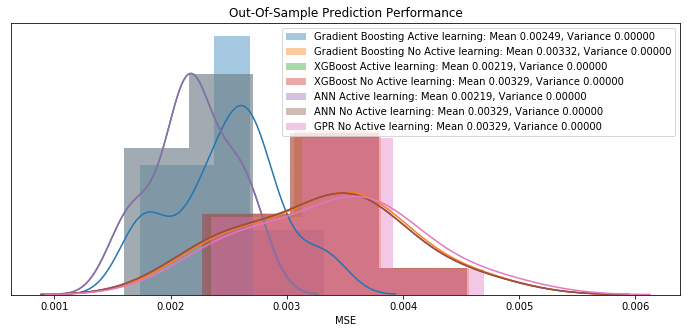

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(mse.iloc[0, :], label = GBAL_label, ax = ax)
sns.distplot(mse.iloc[1, :], label = GBNAL_label, ax = ax)
sns.distplot(mse.iloc[2, :], label = XGAL_label, ax = ax)
sns.distplot(mse.iloc[3, :], label = XGNAL_label, ax = ax)
sns.distplot(mse.iloc[2, :], label = ANNAL_label, ax = ax)
sns.distplot(mse.iloc[3, :], label = ANNNAL_label, ax = ax)
sns.distplot(mse.iloc[4, :], label = GPC_label, ax = ax)

plt.title("Out-Of-Sample Prediction Performance")
plt.xlabel('MSE')
plt.yticks([])

plt.legend()

#fig.savefig("bh_OOS_accuracy_performance.png");

# Average MSE

In [47]:
ave_mse = mse.mean(axis = 1)
ave_mse = pd.DataFrame(ave_mse)
ave_mse.reset_index(inplace=True)
ave_mse.columns = ["model","MSE"]
ave_mse.head()

,model,MSE
0,Gradient Boosting Active learning,0.002485
1,Gradient Boosting No Active learning,0.003320
2,XGBoost Active learning,0.002189
3,XGBoost No Active learning,0.003290
4,ANN Active learning,0.003396


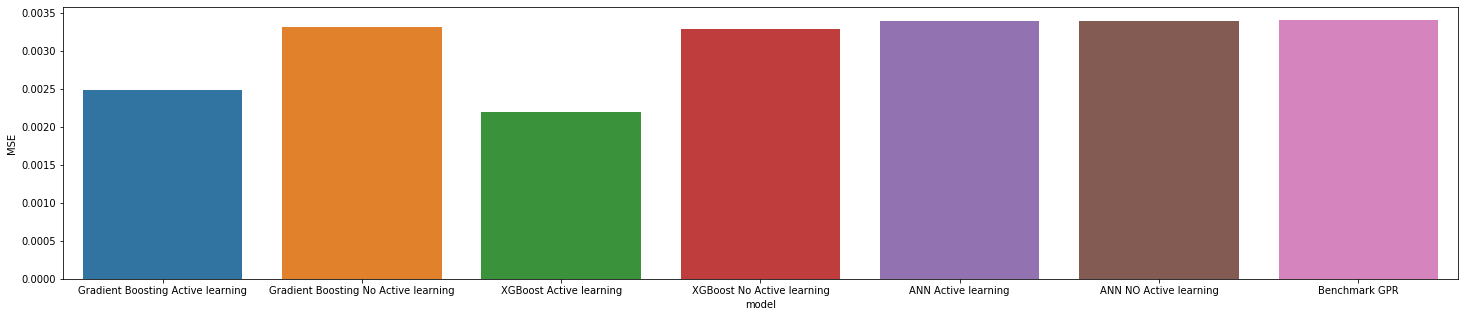

In [48]:
fig, ax = plt.subplots(figsize=(25, 5))

sns.barplot(x="model", y="MSE", data=ave_mse)


# Loop through few budgets

In [50]:
mse_hist = []
mse_ave_hist = []

stride = 500
start = 500
finish = 3000

for budget in range(start,finish,stride):
    # loop denotes which loop are we in
    loop = int((budget - start)/stride)
    
    # Set the ABM Evaluation Budget
    budget = budget

    print("We are at loop: {} with budget {}.".format(loop,budget))
    
    # Set initial evaluated set size, batch size and training pool size
    ini_size = int(budget/2)
    # ini_size = 48
    batch = int(budget/50)
    pool_size = budget*batch
    
    # Build X_train_pool
    X_train_pool = get_sobol_samples(n_dimensions, pool_size, bh_exploration_range)

    # Output data as a csv
    pd.DataFrame(X_train_pool).to_csv("budget_" + str(budget) + "_X_train_pool.csv")
    pd.DataFrame(X_test).to_csv("budget_" + str(budget) +"_X_test.csv")
    pd.DataFrame(y_test).to_csv("budget_" + str(budget) +"_y_test.csv")
    
    # Build train data without active learning
    np.random.shuffle(X_train_pool)    # shuffle it first
    default_X_train = X_train_pool[:budget,:]  
    default_y_train = evaluate_bh_on_set(default_X_train, method, threshold)
    
    # Build first X evaluated batch with size ini_size
    np.random.shuffle(X_train_pool)   # shuffle it first
    ini_evaluated_set_X = X_train_pool[:ini_size,:]
    unevaluated_set_X = X_train_pool[ini_size:,:]

    # Evaluate the train set for the ABM response
    ini_evaluated_set_y = evaluate_bh_on_set(ini_evaluated_set_X, method, threshold)
    
    
    # -----
    # experiment 1
    # model: "Gradient boost" + active learning
    model = "Gradient boost"
    gb_X_train, gb_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)
    pd.DataFrame(gb_X_train).to_csv("budget_" + str(budget) + "_gb_X_train.csv")
    pd.DataFrame(gb_y_train).to_csv("budget_" + str(budget) + "_gb_y_train.csv")
    # model.fit
    gb_active = fit_surrogate_model(model, method, gb_X_train, gb_y_train,batch)    
    gb_active_y_hat_test = gb_active.predict(X_test)
    pd.DataFrame(gb_active_y_hat_test).to_csv("budget_" + str(budget) + "_gb_active_y_hat_test.csv")
    
    # -----
    # experiment 2
    # model: "Gradient boost" + no active learning
    # model.fit
    gb_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)
    gb_non_active_y_hat_test = gb_non_active.predict(X_test)
    pd.DataFrame(gb_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_gb_non_active_y_hat_test.csv")
    
    # -----
    # experiment 3
    # model: "XGBoost" + active learning
    model = "XGBoost"
    XG_X_train, XG_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, 
                                           budget, method, model, threshold, batch)
    pd.DataFrame(XG_X_train).to_csv("budget_" + str(budget) + "_XG_X_train.csv")
    pd.DataFrame(XG_y_train).to_csv("budget_" + str(budget) + "_XG_y_train.csv")
    # model.fit
    XG_active = fit_surrogate_model(model, method, XG_X_train, XG_y_train,batch)    
    XG_active_y_hat_test = XG_active.predict(X_test)
    pd.DataFrame(gb_active_y_hat_test).to_csv("budget_" + str(budget) + "_XG_active_y_hat_test.csv")
    
    # -----
    # experiment 4
    # model: "Gradient boost" + no active learning
    # model.fit
    XG_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)
    XG_non_active_y_hat_test = XG_non_active.predict(X_test)
    pd.DataFrame(XG_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_XG_non_active_y_hat_test.csv")
    
    
    # -----
    # experiment 5
    # model: "ANN" + active learning
    model = "ANN"
    ANN_X_train, ANN_y_train = active_learning(ini_evaluated_set_X, ini_evaluated_set_y, unevaluated_set_X, budget, method, model, threshold, batch)
    pd.DataFrame(ANN_X_train).to_csv("budget_" + str(budget) + "_ANN_X_train.csv")
    pd.DataFrame(ANN_y_train).to_csv("budget_" + str(budget) + "_ANN_X_train.csv")
    # model.fit
    ANN_active = fit_surrogate_model(model, method, ANN_X_train, ANN_y_train,batch)    
    ANN_active_y_hat_test = ANN_active.predict(X_test)
    pd.DataFrame(ANN_active_y_hat_test).to_csv("budget_" + str(budget) + "_ANN_active_y_hat_test.csv")
    
    # -----
    # experiment 6
    # model: "ANN" + no active learning
    # model.fit
    ANN_non_active = fit_surrogate_model(model, method, default_X_train, default_y_train, batch)
    ANN_non_active_y_hat_test = ANN_non_active.predict(X_test)
    pd.DataFrame(ANN_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_ANN_non_active_y_hat_test.csv")
    
    # -----
    # experiment 7
    # model: "Gaussian Process Regressor" + no active learning
    # model.fit
    from sklearn.gaussian_process.kernels import RBF
    kernel = 1.0 * RBF(1.0)
    gpr_non_active = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(default_X_train, default_y_train)
    gpr_non_active_y_hat_test = gpr_non_active.predict(X_test)
    pd.DataFrame(gpr_non_active_y_hat_test).to_csv("budget_" + str(budget) + "_gpr_non_active_y_hat_test.csv")
    
    '''
    print(gb_active_y_hat_test.shape)
    print(gb_non_active_y_hat_test.shape)
    print(ANN_active_y_hat_test.shape)
    print(ANN_non_active_y_hat_test.shape)
    print(gpr_non_active_y_hat_test.shape)
    '''
    
    # Gather all y hat
    y_hat_test =  np.stack((gb_active_y_hat_test, gb_non_active_y_hat_test,
                        XG_active_y_hat_test, XG_non_active_y_hat_test,
                        ANN_active_y_hat_test.reshape(-1), ANN_non_active_y_hat_test.reshape(-1),
                       gpr_non_active_y_hat_test),axis = 0)
        
    # tpr performance
    current_mse = np.zeros((num_experiments, montecarlos))
    for experiment in range(num_experiments):
        for i in range(montecarlos):
            current_mse[experiment,i] = mean_squared_error(y_test[i * test_size:(i + 1) * test_size],
                                              y_hat_test[experiment][i * test_size:(i + 1) * test_size])
    mse_hist.append(current_mse)
    
    current_ave_mse = current_mse.mean(axis = 1)
    mse_ave_hist.append(current_ave_mse)


# to include the first run (outside of the loop) results
mse_hist.append(mse.values)
mse_ave_hist.append(ave_mse)

We are at loop: 0 with budget 500.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.
Surrogate model predicted 4749 positive labels out of 4750: 
Parameters bundles of indices:  [3354 3682 1902 2545 1765 3453  154 3795 1390 3382]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4729 positive labels out of 4740: 
Parameters bundles of indices:  [3610  535  669 4457 2051 3645 4297  532 4627 3165]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 230 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4727 positive labels out of 4730: 
Parameters bundles of indices:  [1177 4334 4033 4302 1762 1476 3791 3672 3242 1752]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 220 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4705 positive labels out of 4720: 
Parameters bundles of indices:  [2114 3596 2930 2057 2019   42 1822 1287  521 4545]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 210 parameter unevaluated within budget.
Surrogate model predicted 4682 positive labels out of 4710: 
Parameters bundles of indices:  [4251  632  981 4163 3410 4121 2088 3419  879 1989]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.
Surrogate model predicted 4667 positive labels out of 4700: 
Parameters bundles of indices:  [ 132 2684 3428 1206 1368  413 3864 3170 3763 4453]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
-------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4678 positive labels out of 4680: 
Parameters bundles of indices:  [3232  629 3708 2329 2204 4638 4228 2844  871 2327]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 170 parameter unevaluated within budget.
Surrogate model predicted 4667 positive labels out of 4670: 
Parameters bundles of indices:  [ 383 1449 1272  302 4126  872 1751 2375 2133 1548]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 160 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4646 positive labels out of 4660: 
Parameters bundles of indices:  [3871 2055 1366 4418  870 2997 1415 1361 3507  977]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.
Surrogate model predicted 4645 positive labels out of 4650: 
Parameters bundles of indices:  [ 996 1970 1247 3181 3240 3691  892 3354 2771 1991]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 140 parameter unevaluated within budget.
Surrogate model predicted 4640 positive labels out of 4640: 
Parameters bundles of indices:  [3326 1836 1272 1370 2970 2102  352 4592 1327 2889]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
-------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4620 positive labels out of 4620: 
Parameters bundles of indices:  [ 138 2154  910  500 1705 2307  158 2878 1309 3108]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 110 parameter unevaluated within budget.
Surrogate model predicted 4602 positive labels out of 4610: 
Parameters bundles of indices:  [2110 3592 2926 2052 2014   42 1818 1283  521 4539]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 2984 positive labels out of 4600: 
Parameters bundles of indices:  [2251 2079  447 3492 3068 3549 4254 1007 3818 4131]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 90 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4588 positive labels out of 4590: 
Parameters bundles of indices:  [4364  531   42 4286 3991  899  544  114 3254  349]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 80 parameter unevaluated within budget.
Surrogate model predicted 3049 positive labels out of 4580: 
Parameters bundles of indices:  [  52  810 1751  838 1529 4537  151  975 1091 2935]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 70 parameter unevaluated within budget.
Surrogate model predicted 3693 positive labels out of 4570: 
Parameters bundles of indices:  [ 663 3679 1072 3868 1494 1954 2866 2510 4511 3095]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
---------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4549 positive labels out of 4550: 
Parameters bundles of indices:  [ 533 2813  582 1831 3380  651 2481 1461  138 4103]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 40 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4539 positive labels out of 4540: 
Parameters bundles of indices:  [4305 1965 1865 4316 3176 1531 2081 1141 4198 3175]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 30 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4523 positive labels out of 4530: 
Parameters bundles of indices:  [1497 3508 2353 3653  482 2934 3502 4218 3505 1006]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 20 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 4511 positive labels out of 4520: 
Parameters bundles of indices:  [4217  586  159 4373 2313 2823 3089  943 3409 1965]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 10 parameter unevaluated within budget.
Surrogate model predicted 4502 positive labels out of 4510: 
Parameters bundles of indices:  [3734 3047 2622 2511  170 1236 4052  533  585 1494]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 250 parameter unevaluated within budget.
[20:13:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 2817 positive labels out of 4750: 
Parameters bundles of indices:  [4515 1023  207  430 2726 4579 1243 4440 4082 2778]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.
[20:13:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 4740 positive labels out of 4740: 
Para

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


[20:14:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 3078 positive labels out of 4720: 
Parameters bundles of indices:  [1118 2481 1010 2273  600 3971 2131 4036 3745 3835]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 210 parameter unevaluated within budget.
[20:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 2862 positive labels out of 4710: 
Parameters bundles of indices:  [2610  954   67 4264 1478 3696 3179 2575 1874 4378]  are randomly selected from positi

[20:18:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 2566 positive labels out of 4580: 
Parameters bundles of indices:  [4126 2922 1599 3862 2512 3366  556 4412 3474 1242]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 70 parameter unevaluated within budget.
[20:19:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 2569 positive labels out of 4570: 
Parameters bundles of indices:  [4357 4445 1504 4436 3138 1711 3116 4073 3243 4260]  are randomly selected from positiv

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 14 positive labels out of 4740: 
Parameters bundles of indices:  [ 172 1174 3803 2792 2606 4629 1855 3393 1553 1397]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 230 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4730: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3421 1806 4672 3440 2052 4728  926 2662  869 2873]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 220 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4720: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2011 2693    8  174 3626 1348 4238 4411 3698 4004]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 210 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 4710: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2235 3794 1066 4400 1750 2215  729  197  441   24]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4700: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3893 1184 4381 2248 1197 1547 2112 2108 4140 3082]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 190 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4690: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 326  436  309 2499 1369  771  663 3955   95 2237]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 180 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4680: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4196 4123 2030 2305 4646 1300 4109  109 2003 2659]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 170 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4670: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4120 1731 1357 1368 4095  831 3862 2201 1196 2650]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 160 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4660: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3892 4207 3655  345 1232 1845  358 4186 1858 3022]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4650: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2354 2876  931  200 1172  487 3011 2475 3605 1870]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 140 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4640: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [3986 2205 2363 3336 3943 2406 2374 2034 3363 2273]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 130 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4630: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4151 1341  265 2143 1373 2132 1330 4560 4493 2820]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4620: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 908 1351  815  947 2546 2398 1314 2300 1253 2733]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 110 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4610: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [2780 1913  619 2107  827 1940 4067 1266 1956  193]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4600: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 891 4009 3793  811 4082 1036  350 3324  221 3985]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 90 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4590: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 801 4328 3643  824 3558 1157 4168 3903 2892 2957]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 80 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4580: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 465  553 2751 2127 1663  425 2210 1193 3993 3144]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 70 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4570: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1039 1117 1520 1771 2660 2146  367 1629 2565 3729]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 60 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4560: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1208 1356 4515  917 3484 1355 2692 4264  647 3896]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 50 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4550: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 235 2308 1672 4506 4419 3312 3351 3246  778 3792]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 40 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4540: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4133 4180 3574 2896 1600  398 4266 1228  749 4299]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 30 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4530: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [4160 4515 1569 1768 3282 3166 2470 2474 1032 1051]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 20 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4520: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [  90 2598 2357 3177 1045 1948 3223 3840 2249 2665]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 10 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 4510: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [1939 3361 1466  173 2510 4096 2152 1002 1260 1613]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


We are at loop: 1 with budget 1000.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 500 parameter unevaluated within budget.
Surrogate model predicted 19500 positive labels out of 19500: 
Parameters bundles of indices:  [18123  4508 12610  1289  1832 19153  2297  1190  1943  6028 11437 18703
  7508  7082  2092 13359  3645 14542  3033 13006]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19477 positive labels out of 19480: 
Parameters bundles of indices:  [ 1354 10502 15644 18315  5149  3488  5496 16851  7723 11309  6670 15473
  7418 12187  9941  8341  3221  6090  8334  9932]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 460 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19460 positive labels out of 19460: 
Parameters bundles of indices:  [  651 13205  9370   448  3522  2670   775    51 13316  1727 17160 17650
  8992  9132   390  4367 11173 12413 13848 12086]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 440 parameter unevaluated within budget.
Surrogate model predicted 19427 positive labels out of 19440: 
Parameters bundles of indices:  [18326 11861 13253 19041 16597   390 13441  6094 16894 18006 11167 18618
 17711  4660  2974 14573 11018 14936 18133  7475]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 420 parameter unevaluated within budget.
Surrogate model predicted 19420 positive labels out of 19420: 
Parameters bundles of indices:  [13418 13953 16451 14528  8295 18672 17374  9

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19400 positive labels out of 19400: 
Parameters bundles of indices:  [17158 18466  4597 18738  2157  8733  7674  2190 13155 17794   385 18520
 16579  9594 10117  1467  5987  7875  9551  9866]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 380 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19380 positive labels out of 19380: 
Parameters bundles of indices:  [10697 15466 15847 13542  6409   624  8569  9426 18116 12247  6423 14080
  1013   148  7441 17277  7072 10335 15799  7513]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 360 parameter unevaluated within budget.
Surrogate model predicted 19359 positive labels out of 19360: 
Parameters bundles of indices:  [15641  3913  6292 11767  5849   841   888   693 13248 13043  2383  1416
  6161  6045 12422  3416 12370  4402 10922 16267]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 340 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19340 positive labels out of 19340: 
Parameters bundles of indices:  [ 5253 12734 13756  1583  7760 15692 11126    51  7751 11881  7375  8240
  3824 17995   390  2466  1418  9269 11880  2108]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 320 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19320 positive labels out of 19320: 
Parameters bundles of indices:  [15782  8645 10170  3144  4583 10367  7751    51  8979  8863 12026   809
  5909  8217 17088 10880 17635  7406   841 17953]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19300 positive labels out of 19300: 
Parameters bundles of indices:  [16816  6617 16804 15129  2795 12184  9438  5411    33 15902 12905    51
  6893 18586  8429 10980 13988  2310  8580 10812]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 280 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19280 positive labels out of 19280: 
Parameters bundles of indices:  [15262  7474   183 15018  6687 16449 14523 10822   148  3951  6956  3253
 14902 13908  7489  4346 14235  8868   998  7523]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 260 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19238 positive labels out of 19260: 
Parameters bundles of indices:  [ 8655  3917 10025 15807 14834   842   889   694  9542 13060  2386  1417
  9995  6053  4964  3419  7260  8035 10937 10362]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.
Surrogate model predicted 19136 positive labels out of 19240: 
Parameters bundles of indices:  [ 8185  9358  9937 16915 10150 13343 14569 15642 15290  3456  5026 15207
  8577  2766 17121 12032 16479 15129 17336 15733]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 220 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19126 positive labels out of 19220: 
Parameters bundles of indices:  [16235 11515  4172 10934 13364   183 13599  3827   880 11378 14094  7373
 15129 16956 16998 18281 11999  5031 12213 10515]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19194 positive labels out of 19200: 
Parameters bundles of indices:  [ 5605 18328 17273 18343 12379  9643  5373 10876 12229  6574  5020 17769
  7134  6208  8726 10011 11455  1525  9561 17418]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 180 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19180 positive labels out of 19180: 
Parameters bundles of indices:  [15593 11787 15751  7184 13064 16092  3480 14338  6939 17745  3093 15788
  3695 13639 16994  8332  3516  6999  5880  2601]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 160 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19160 positive labels out of 19160: 
Parameters bundles of indices:  [12943  1274  6582   448   220  9537 13574  9865 15639 18006 12740  2179
  8269 16417 15640  2118 17602  9412 11738  1557]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 140 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 18564 positive labels out of 19140: 
Parameters bundles of indices:  [ 1226 12792  2246  9372  6940  9659 10846 15044  3748  4813 13234  2984
 18994  7063   225 13999   733 11851 18654 15643]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19120 positive labels out of 19120: 
Parameters bundles of indices:  [ 5036  7091  5076  1593  3240 12934  3832  6894  8482 11566  4755 13999
  8053  3047   448  1957  7180 16720 17367  2901]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19100 positive labels out of 19100: 
Parameters bundles of indices:  [ 3813 11841  3850  7950  4610  1343  5386  6768  9296 11266  5540 15217
  2952  1018 19051  8140  2359  3012  3249  3907]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 80 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19080 positive labels out of 19080: 
Parameters bundles of indices:  [ 6716 10284 14413 16097  9044  7902 13999  4755  3695  5157  8467 16550
  9982  2535  2841  6349  2763  7568 16040 16341]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 60 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 18376 positive labels out of 19060: 
Parameters bundles of indices:  [ 4416 18247  2101 13568   683  1528 17638  8575  2316 16205   302 15071
  3598 18396 11692  8256 11222 17499  9925  4947]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 40 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 18716 positive labels out of 19040: 
Parameters bundles of indices:  [ 8090  9350  3644 13809 16745 14475  6285  5237 11455 14585 15249  9416
  8482  2179 12798 18382 13761 18651  9039 16238]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 20 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 19020 positive labels out of 19020: 
Parameters bundles of indices:  [10171  5933  8920  1195  3522  9737 18972  8101 12476 17087  7899  8174
  5918 15714   768   385 16538  7595  5921  2980]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 500 parameter unevaluated within budget.
[20:46:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 19500 positive labels out of 19500: 
Parameters bundles of indices:  [18123  4508 12610  1289  1832 19153  2297  1190  1943  6028 11437 18703
  7508  7082  2092 13359  3645 14542  3033 13006]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


[20:47:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 11255 positive labels out of 19480: 
Parameters bundles of indices:  [18498  3684  3254  4367 14038 17385 14901 17258  3313 16364 18963  5268
  5955 18999  5855  5249 14155 14789  9103  6028]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 460 parameter unevaluated within budget.
[20:47:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 19460 positive labels out of 19460: 
Parameters bundles of indices:  [  651 1320

[20:53:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 10316 positive labels out of 19220: 
Parameters bundles of indices:  [16335 15158  1793  7663  8623 10445 10174 18094 17431 11661 14802  5392
  5839 14445  4190 16680 14162 18688 13817 12186]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.
[20:54:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 10434 positive labels out of 19200: 
Parameters bundles of indices:  [11283 1387

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19480: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2528  3673  8940  4062  9399  7976 16199  7499  3901 14705 18833  6813
  5022  6615 13426  4834 16272 11531  7317  4663]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 460 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19460: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14604 17089 12087 13145  8058  9430 11282  4300  1202  1591 18359 11575
   114  2417 15307  6360 13975 14125 14018   511]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 440 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19440: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18307  1169 15081 14090  8330 19104 19260  4951 18066  2502 14296 12617
 16166  6906  2104  5953 19374  2961 13318  7444]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 420 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19420: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6370  8322 11674  9435 17062 12050 11673 14208  6240  6433  9458 16794
  1459 15729  2597 14052  2759  6084    90  6767]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19400: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15051 11532 14148 17325 18903  9434 14408  4503  4109 10129  8083  8688
  3008 11551 11684 10435 12178 17349  4399  2472]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 380 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19380: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 3717  9072 15743 13756  8943  1845   689  5446 13919  9589  6490 12737
  1970  4670  7745  4536 16472  7150  2332 10337]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 360 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19360: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18052  4906 16146   824 11787  4389 18379  6023 14127  2709  8701  5724
 18661  9101   828 10192  1025  2205  5345 18807]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 340 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19340: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8682  4397  3839  9190   348  7325  5352  9951 15980  1886 14422  8327
 17674 10108 12026 12429 10704 13418 13510 11521]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 320 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19320: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14332  2488  1305 14520  8986 10638 13526 12883 10564 15106  1186  4928
  8058 14521 16788 12637  6775 13633   289 16637]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19300: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6602  6971  3178 16066 13802  1491 18307  5006 14741 18077 16041 16464
  5784 16651 14704  2403  1756  9402  3057 15546]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 280 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19280: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16984  3097 11309  4680 11533  2591  3360 16411 12979  9123 18912   188
 18465  6306 18046 13743 11009 12753  5751  2991]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 260 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19260: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14997  5180 16834  5360    55 18685  6880  4565 12696 17822  2531  9251
 16382   708 10155  8391 11041  3782  7171  8043]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19240: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5818 13716 13357 12318 14342  4047 12490  9862 18300  5777   658  5691
 12187 16716  2467  5798 19189 17266  2862  6738]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 220 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19220: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 9510 14475  1978  9652  7421   430  3341  1956  6808 13742 12293 11505
  9622  1854 10515  4308 16248  4192 15809 10725]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19200: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5821 18371  3929 11925 18875  2461   472  4800 18307   747 18849 10117
 12714  4194 17677 19181  3045 11722  5500  1451]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 180 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19180: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 1479  5056  8290  2383  9267 10901 18043  3427  5234 16041 10357  5195
 11776  9598 18861  5207 10359  4708  8120  3254]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 160 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19160: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18000 13697  3037  6062  8075 11456 17121 11078  7083 18345 13775 17407
 13197 16270  5722  8112 19129  7798 10178 14762]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 140 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19140: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15837 14905 18549  8778  5727 14838  7595  1200 14628  9364 11978 17234
  4128   712  1768  7950  3485 11264 14678 12264]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19120: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [18048  6338  5594  1901  4754  1592 13148 15534 12983  7841  6306  6158
 15526 14912 17412  3666  6994 16266  8364 12639]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19100: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [15042  8512  8567 17275  6121 11505  1643  8487  3645  9654  4816  4652
 16208  9924 11631  3145  4834 10492 13455  8461]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 80 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19080: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [17022  7103 15311  8180  2933 16607  3795  4289  6503  1275 13771  3781
 13690 17285  4298 15341 16991  9037 17769   538]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 60 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19060: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [19049  3166 10946  1556 15357 10902  2607  1151  7693  5226  9778  1346
  7708  7539  4704 11847 14133 14454 13546  3587]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 40 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19040: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13538 18505 11559  4847 11398  5069 16379  5543 17879  9502 15788  6942
   984 14641  2905 10808  9623 12662  6446  1762]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 20 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 19020: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5018  9250  1639 10669  5318 13767 11696  5964 17702 15382  4984 12269
   958 11792 19019 10421  6525 13918  2346 18139]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


We are at loop: 2 with budget 1500.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 750 parameter unevaluated within budget.
Surrogate model predicted 42926 positive labels out of 44250: 
Parameters bundles of indices:  [14176  8481 26485 16253 32548 43469  8806 43848 15820 22870 13630 36783
 26839 39286 42011 12341  3816 25469  5887 37298 20075 22948 39084 28026
 17158 27484 19049 34952  4628 25612]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 720 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 33687 positive labels out of 44220: 
Parameters bundles of indices:  [21982 19308 41527   530  6696 12202 11946 23224   771 40823 35147  4969
 34550 32081 42698  9316 16851 20577 36001 20095  7571 24176 43083 16699
  3322  2896 10933 31055 24648  2935]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 690 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 36970 positive labels out of 44190: 
Parameters bundles of indices:  [ 3888 23838 40659 13300 31552 36212 39423 40419 14163 18052 31540   231
  1894 23263 34662 24208 41639  6343 38344 38851 17523 23268 20723 20712
 38882  9421 12664 43623 37365  6121]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 660 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 36915 positive labels out of 44160: 
Parameters bundles of indices:  [ 1986 32997 44153  2296 16862 33860 23817 40003 30158  7325  4393 31548
  5853 12176 18133 15851  5773 43185 37449  3603  2157 39102 43126 30589
 32287 43581 28041 23504 39146 33259]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 630 parameter unevaluated within budget.
Surrogate model predicted 36883 positive labels out of 44130: 
Parameters bundles of indices:  [36158 32678  4201 36452 40744 29608 27889 19939 11308 19518  8008 36123
 10743 13246 33476 36834 24269 34116 16802  7260 11120 29465 26484 44079
 20504  2629 23102 20759 25605  7007]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 25293 positive labels out of 44100: 
Parameters bundles of indices:  [33371 29884 37073 25050 12902 14528  2506 15046 34983 41812 26658 11215
 11316 16841 29586 35679 19271 38591  8252  8039 16483  3933 19976 25171
 16017 17481 15940 25359  7954 23072]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 570 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 23481 positive labels out of 44070: 
Parameters bundles of indices:  [18773 15097  1212  9604 40452 10333   937 20832 19286 32051  5672  7681
 14517 28148 28461 27414  7997 14451 27346 22209 22897 12818 37817 43698
 27547 12896 10856 40743 41750  2267]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 540 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 43280 positive labels out of 44040: 
Parameters bundles of indices:  [22981 31059 14643  4535 22893 19805 20902 41844  1698 39186 39139  8362
 20224  7988    87 17304 32653 37185 35735 31581 31544  5210 27672 31800
 37330 37842  6722 17328 11647 19258]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 510 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 36394 positive labels out of 44010: 
Parameters bundles of indices:  [40331  8877 16823  1545 18823 40898 40774 13558  1979 20839 17228 40517
   480 41764 33479 12774 34439 28158 21018 19207 26956 31204 22057  2503
 14153 25663 12831 39855 39827 25153]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 29149 positive labels out of 43980: 
Parameters bundles of indices:  [ 3129 30923 12428 20861 34785 39593 17526 35867 13009 34682 18244  5419
 30873 15035 37935 31882  6505  4562 43559 42657 41080  8431 18365 25659
 39615 12195 35561 26018  5589 30040]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 36919 positive labels out of 43950: 
Parameters bundles of indices:  [15862 10911 42345 16298 36885 13100  8492 37773  4717 33224 23089  5531
 24079 38217 29796 39833  5534 33638 20150  6041  7945 14059 25962 22050
 15035 42368  8974 23725 31911 31894]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 420 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 42717 positive labels out of 43920: 
Parameters bundles of indices:  [35195 15063 21610 12265  9322  8195 33544 37623 33476 38876 21262 18319
 10949 36308 32837 15157 39687  9104  6256 33321 14003 21976   725  1343
 35788 41163 28005 12685 42716  6141]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 390 parameter unevaluated within budget.
Surrogate model predicted 36519 positive labels out of 43890: 
Parameters bundles of indices:  [  522 10059  1925    23 24695  7212   933 11733 38227 17442 37074 25904
 11761 41159 14199 11193 18480  9873 34602 43019 11758 13928 40724 17895
 21028 35935  8980  8866  8632 20283]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 360 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 37061 positive labels out of 43860: 
Parameters bundles of indices:  [  301  7172 40769 12162  5192 27362 37282  2913 23056 34795 37579 10119
  2032 42912 38510 15447 15079 36426 40921 20902 43726  4048 15486 11851
 17159 22587 34509 35753 42655 16656]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 330 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 29364 positive labels out of 43830: 
Parameters bundles of indices:  [25107 24019 11446  8874 42068 39373 14370 26991 36611 35134 30941  3979
  7956 15388 22272 21511 30377  6960  6608 40479  2160 28769 19106 20714
 41280  5546 12033 18385  1943 40181]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 39999 positive labels out of 43800: 
Parameters bundles of indices:  [23364 27335 17232 29837 14801  3449 20461 20908 31975 26441 42275 29204
  4939 11969  3556 23320 26932 12867 26893 29748 18915  4117 23319 34428
 11251  3663  3865 14568 38692 16817]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 270 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 29334 positive labels out of 43770: 
Parameters bundles of indices:  [ 3066 30595 12157 20608 35960 39203 17273 35432 12775 34264 17984 43669
 30549 14814 37561 31528  6365  4457 43092 42166 40631  8224 18102 25438
 39221 11917 35120 25756  5486 29714]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 30265 positive labels out of 43740: 
Parameters bundles of indices:  [26292 39408 19017 28297 31632 39863 38749  1113 29735  8357 30904 21805
 23416 36786 19548 16766 28840 33767 35502 12959 14900 29045  6882 40894
 37177 27056 20436  3453 19191 27892]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 210 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 38025 positive labels out of 43710: 
Parameters bundles of indices:  [20394 23685 34933 22087  1458 29001 34848  8710  8290 15618 40185 16141
 37305 13341  4852 25773 30849 22761  6276 31046 33905 28140 27398  1225
  8394 15034 35648 19907  1101 34643]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 180 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 25309 positive labels out of 43680: 
Parameters bundles of indices:  [ 5757 22312 18100  1839 25924 41265  4424 31006 42288 37425 30509 40488
 43150 42629 25225 22681 38144 16521  2504 16014  3705 14348 27007 18272
 27523 16545  1242 12922 31017 32415]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 38048 positive labels out of 43650: 
Parameters bundles of indices:  [16449 15541   221 32639  6389  8768 28208  2791 29877 34485 26160 40421
  2308 13031 41578  5324 31060 30959 18371 13977 24092 26875 33544 26844
 21241 22772  1098  8550 15266 13240]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 37377 positive labels out of 43620: 
Parameters bundles of indices:  [ 7695 32097   289 29849 24913 26079 18944  9064 13802 35332  4225 33199
  1231 15414 13144 13411 25939  3838 27138  3612 42354 19640 36864 36982
 13140 19156 42791 14351 42774  5061]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 90 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 25809 positive labels out of 43590: 
Parameters bundles of indices:  [29325 36090 17982  9871 18009 20979 28931  8389 30330 35063 24628 37214
 29736   901 34971  8199 27314 27692 29468 17316 24401 10955 19877 31457
  1680 39074 12220  7595 38080 32776]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 60 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 36859 positive labels out of 43560: 
Parameters bundles of indices:  [38394 38862  6379  6812 20999 37230 22286 27723 34292  8583 30504 24218
 35911  2748 42610  9217 34227 12953 21588 31038 21663 14465 40370 41973
   485 35690 13995 26925  3737  5008]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 30 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 38197 positive labels out of 43530: 
Parameters bundles of indices:  [ 9414 35462 34102 21433 31172 23685  8222 31907 13196 11749 11850 39489
 28318 20540  1115 31296 18504 26341   456 34666 18410 19178 35434  8498
 15526 39721 41765 34242 42783 37809]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 750 parameter unevaluated within budget.
[21:45:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 22810 positive labels out of 44250: 
Parameters bundles of indices:  [35966 11647 32989 39593 27280 24413 36848 37453 24770 40823 24022  1589
 37312 18356 31005 41512 29491 24009 29325 25007 27054 19876 38450 34750
 42312  2363 24709 31459 16725 26840

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


[21:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:45:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 23794 positive labels out of 44220: 
Parameters bundles of indices:  [10391  7609 35932 41713 21904 32468 22726 43683 31961 14508  8265  7280
 32650 12672 17717 17223 18003  7454 11135 33268 41126 23525 31756 25796
 11986 29172 11411   119 41042 41767]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 690 parameter unevaluated within budget.
[21:46:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:46:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 27500 positive labe

[21:53:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:53:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 22900 positive labels out of 43860: 
Parameters bundles of indices:  [27530 31383  9204 36716 43510  8945 29778 12319  3211 19073  3728  2054
 22100 27403  3086 38181 33498 13528 23815 33610 27545  8449  9703 32729
  1740 13843  2559 16924 35154 11833]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 330 parameter unevaluated within budget.
[21:54:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:54:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 21954 positive labe

[22:04:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:04:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------------
There are still 750 parameter unevaluated within budget.
Surrogate model predicted 19 positive labels out of 44250: 
Parameters bundles of indices:  [ 1482  3521  6867  7448 10246 10809 15406 17614 19155 21108 22354 23079
 24596 27683 34647 39467 40393 43103 43144]  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8493  9019 13052 39476 35120 33685  1389 41605 28652 36882 11498]  in the rest of th

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44220: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [22158 33359  4087 22407 17080   780  7296  4020 15797 31933 28835 26786
 22315  3819 24383  9463 37683  9242 36761 24910 16726 11607 23073 25834
  6500 43636  7795 31630 43281 43266]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 690 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44190: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [33086 30234 31025 31524 32631  7094 14540 11290 10260 13535 28042 26888
 21183 38437  5483 26261 12547 25785 31656 32328 21154 20226 42287 10720
  8898 14761 33432 41416  6055 16068]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 660 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44160: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [34454 26590  7538 15375 20731 22996 19302 30334 38022 12365 26673  8603
  6284 33030 22680 31512 14602 39643 14027 11917 18735  5650 41739  7211
 28055 18235  7599 24344 36836  1921]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 630 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44130: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [30978 10700 14590 40631 19094 19083 43548  7316  5511 27703 36592 21200
 18594 35552 26107  2429 10102 35932  2387 22008 35822 43627  8079 43768
 30926  6050 42564 37818 29989 39270]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44100: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [33628 26169 39930 17229 31545  5361 30661 25410  6903 30394 11190  9401
 35691 10834 15903  6182 41374 21314 43609 24286 42706 26288 16672  6065
 38960  9086 10483   828 17716 38621]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 570 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44070: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [33429  2291 34642 39796  5023 22970 40588  7707 24097 21168 43599   925
 39706 31193 38376 37964 32040 15218  7683  5832 31239 21095 21823  6981
 21814 15032   906 14609 23085 40608]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 540 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44040: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [31591 42750 26816 10961 26415 11514 38097 12692 41371 21901 36716 15954
  2075 33962  6570 24920 22143 29425 14767  3858    18  9692 12807   696
 35758 26264  2296 29090 42858 36868]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 510 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 44010: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [40079 33948 19571 32902  4553 41055 37842  5434  6158 13950  7292 37829
 36668 24065 28813 25798 18941 13288 31948 39799  3579 18618  3859 12085
 22335 16696 23968 38767 22122   547]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 43980: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [13298 43910 24717 34872 15660 34907 33269 32931 12414 35368  8546 41987
 12978  1311 42468   313 33411 32343 40512 31103 32250 14101 30670   369
 21210 13165  6593 39219 2639

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43950: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [26407  7321 13595 42389 24888 24906 23144 36649 42625 29119 34755 39886
 13989 33749 31884  7382 42861  2754 25642 24664 23915 19105 40041 27411
  2374 43616 21547  3365 36881  5322]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 420 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 43920: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [36074 38801 13926 12141 37683 18763 41912 24674 43189  7553 23438 22616
 41858 17515 31290 22922  8189 37993 31330 21584 41498 16777 27306 24077
 17169  8051 32843 25281 2215

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43890: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 2109 16556  4888    59 23314 19401 27795 23284   939 35924   625 31976
 35032 18575  2256 38365 21343 27565  8791 25896 21329  5186  2276 40030
 35722   201 19121 43420 20367 29169]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 360 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43860: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [26350 31565 26514 32880  5064 34220 37402 23106 20630 16319 21003 41597
 31862  2274 35367  8011  8607 37060  9965  2492 38627  9482 41497 19684
 36637 30527  7447 29422 15547 36069]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 330 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43830: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 7894  8892  8981  2227 29353 31733 30997 25171 40934 33440  6585 43809
 36302 30220 31745  5631 24058 32807 30906  7975 41631 22693 35392 40663
 14048 11190  5664  3325 40576  3693]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43800: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [23995 31847 22895  3186 25968  9820 40387 11722 22775 40850 35869 40204
 16332 24489 34008 15762 36697 29394 27296  5050 28580 31908 36542 11739
 21870  7207 23821 26512 33010 16435]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 270 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43770: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [42578 26106 13886 10047 28843  3295  2157  9259  2845 34151 11652 15402
  1098  9981  3718 16538 20555 16673  5173  8578   336 31969 34710  8430
 40974 38257  9103 10716 12768   346]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43740: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [23852 12391 31853  2225 37429 26459 41501 31083 37925 37817 12890 39247
 43471 18419 10405 39387 41884 22895 38205 28415 42498 24923  7805  3371
  2596 14405 21000 15411 39699 33600]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 210 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43710: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [16825 40919 15109 43400 16211 20386 22545 36056 16079 29322 42334 30042
 22247 26132 43534 11934 31633 36855 42952 19145 24941  9240  3139 32814
 22140  8299 29597  6041 33987 36238]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 180 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43680: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 4574 31066  5209 30021 28587  7000 15568 25235  5748 27944 25550 29740
 40802 14858 42614 23637 23612  9369 17136 15588 31390 31589 18349 23802
 16800  3579 13933 16445  3734 16028]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43650: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [36329  4589 18159   134  3413 40998 39804 30107 42378  4513  7855 36646
 32513    47 38437  5928 31132  4949 32407 32424 27245 16374  2363 10432
  3964  9069  1270 23073 37145 42219]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43620: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [32829 37887  3386 40931 37045 39771 11713  3655 17584 39597 36669 25378
 24146 21208 41857 38776    44 37302 17089 29186 30540 17854 32104 41796
 10310  7318 32261  9090  3515 20318]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 90 parameter unevaluated within budget.
Surrogate model predicted 0 positive labels out of 43590: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [37637 31034  6196 20758 39097 13977 40381 41291 20127 21948 36522 35357
  1654  5049  9330 24290  3194 15490 10672  6969 19785 11319 40556 37208
 15874 13808 38091 16487 32945

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43560: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [14489 33735 23278 25755  5057 20769   150   922 22097 22092  1143 14754
  3061 30319 23112 40057 32485 39695 29374 41271  8764 30258 14050 42044
  9397 17796 32077 39454  6056 24190]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 30 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 43530: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [37701 10505 27205  2250 15201  9158 32616  3366 19526 15042 22476 14425
  1605 32486 24268 14577  9605   733 35748  5845 31346  6264 35480  6993
  3935  2236 33286 12492  3735 32309]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


We are at loop: 3 with budget 2000.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.
Surrogate model predicted 78999 positive labels out of 79000: 
Parameters bundles of indices:  [42637 39378 17266 53801 25762 66538 11008 63091 50493 14185 66661 45563
  2499 12282 32400 27453 23125 57337 76580 17551 59123 57245 24364 26828
 29458 15568 44450 59393 58439 39237 59388 38619 15049 46959 68590 46840
 66134 26823 47986 41992]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 960 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78957 positive labels out of 78960: 
Parameters bundles of indices:  [76359 43473 61281 20667 52685 22914 54698 10963 62206 69692 45307 57107
 16963 16737 28500 54439 45006 24105 76584  9055 64975 77789 40255 74806
 58119 28620 28918 68538  8659 48166 48319 16373 12972 71990 41636  1882
 26595 26302 22908 23780]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 920 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78920 positive labels out of 78920: 
Parameters bundles of indices:  [63388 74715 44455 26012 46824 68775 75518 23323 55420 48245 24873  3070
 52717 54622 38096 17061 76458 75811 66902 35487 36047 77049 74027 71993
  1562 39360 34817 63887 42340 24720  3049 14313 37221 25176 71770 75782
  3787  9414 43636 74742]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 880 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78781 positive labels out of 78880: 
Parameters bundles of indices:  [31239 70850 57405 56966 24151 47936 39416 63957 20245  1366 48909 45925
 10972 71334 47120 75393 25270  2853 76835 15206 34275 30246 74915  8654
 54706 43834 60570 42314  8765 67912 37946 73786  6236 64184 50016 24393
 53038 77401 29147 15433]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 840 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78720 positive labels out of 78840: 
Parameters bundles of indices:  [11068 58600 23589 36008  9827 61041 42020 61487 56107 69363 54155 34942
 67392 44008   941 36432 69415 55896 64972 35223 66622  7968 34920 21059
 37840 54016 47733 52197 70387 14596 35205 39471 34111 28099 55587 31609
  1160 60491  3612 42958]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78800 positive labels out of 78800: 
Parameters bundles of indices:  [38038 17393  8694 61831 17114 33199 29869 70099 20219 71946 62807 57028
 58270 19421 64802 49774 46472 63703 16735  8674 70521 48305 18712 24475
 73584 53512 23328 32949 15244 61152 45026  1700 56690 78451 15631 47221
 38017 68118 57557 53413]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 760 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78760 positive labels out of 78760: 
Parameters bundles of indices:  [44291 59563  6782 75369 58908 12526 55092 31772 51094 57991 32984 20751
 13182 36459   857 49052 51231 77262 32485 27127 22908 45085  6642 28850
  1806 14448 52240 59241  4263 63908  3340 76910 28414 15103 77944 52025
 32588 26693 48304 67863]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 720 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78691 positive labels out of 78720: 
Parameters bundles of indices:  [53430 68504 63623 38144 46086 26850 38266  6623 51008  1365 59230 50914
 15775 58736 11787 75329 76864 28443 10851 51144 73026 77769 42617 36286
  6858 76279 27268 25344 39284  7846 22126 63543 24973 63104 22232 49940
 42466 44080 55874 30197]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 680 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78628 positive labels out of 78680: 
Parameters bundles of indices:  [21222 64588 22365 18248 26337 30874 74270  7410 27385 73893 75526 26224
   940 14721  1367  2871 35576 26445  6792 54680 23644 58028 45108 59669
 51982 54672 44087 27442  1183 51227 16784 61032 65473 50108 63346 69601
 10093 64083 16237 72653]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 640 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 75968 positive labels out of 78640: 
Parameters bundles of indices:  [68297 12909 73308 53116 58278 67566 17386 60594 45188 77786 27900 10953
 50571 63536 38806 10638 10085 13640 42557 42284 49794 15620 49652 58434
 50230 49919 39934 39986  5169 20738 76057 41329 71001 73022 62490 46076
 29719 10033 48738 52681]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 64690 positive labels out of 78600: 
Parameters bundles of indices:  [21675 70642 78374 23793  3427 17009 43888 75429  3980 17784 75661 25270
 58606 44696 11786 55294 61970 50580 11271 51117 52858 58739  5590 50037
 31025  6545 62992 49270 40352 54012 35421 25266 34851 11999 65846 39485
 33091 12901 48954 49791]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 560 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 78528 positive labels out of 78560: 
Parameters bundles of indices:  [36609 36430 64750 50145 22171 63059  1009 63838  9890 25623 50860 24088
 41284 27908 11718 70557 44032 12416 23425 68662 38958 58155  3485  3053
 38662 59318   214 56955 10751 41482 40606 46686 67738  3955 36573 10990
  4351 56861 47388  3533]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 520 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 64846 positive labels out of 78520: 
Parameters bundles of indices:  [48778 58319 28047 76632 20465 53552  5546 23371  5128 42465 21826 35179
 47174 41266 16413  4166 31364 19557  7302  1449 52678  9701  2569 30456
 42160 67387 37434 74707 27696 19116 55454 32891 49679 58998 36433 77805
 35889 57622 56625 20862]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 43346 positive labels out of 78480: 
Parameters bundles of indices:  [10892 38591 67374 51134 21814 67735 60888 57404 70441 19087 24483  5045
 47488  4584 31620 37033 54695 70981 32726 63187  6663 34164 27660 74227
 55250 64063 72588 40928 14611 54982 77489 74652 74391 45673 66927 40874
 50238 13385 69090 76557]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 440 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 64063 positive labels out of 78440: 
Parameters bundles of indices:  [50282  4075 27361 44633 51547 77427  9157 34239 50227 57319 66792 40535
 34178  4276 36917 76356   916 26143 51526 27513  3907 11269 67447 61024
 67438   192 60746 35020  8001 35267 77066 59235 30824 71619 16467 36180
 51847 76543 18411  5257]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 45239 positive labels out of 78400: 
Parameters bundles of indices:  [14958 20810 34704 11301 24894 33368 18971 29952 42363 50069 24912 29447
 74278 48226 45039 21488 64767 47601 70349 69795 20109 74822 32601 66058
 42291  5546 53594 13334   136 67501 39930 19616 65354 15766 34091 37875
 46241 43504 78084 51158]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 360 parameter unevaluated within budget.
Surrogate model predicted 47968 positive labels out of 78360: 
Parameters bundles of indices:  [67116 65536 49600  6200 51244 21639 13369 41043  5548 45012 18377 20358
 40469  4329 48337 21481  7233 44778 59852 71414 56183 56784 46529 28974
 20787 45385 51356 50904 77589 73932  8002 60686 28980  2543 26153 42884
 34187  2557 77043  5133]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
----------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 47820 positive labels out of 78320: 
Parameters bundles of indices:  [13216 28777 15481 44954 35348 35964 58230 11766 73776 30264 66955 35660
 29035 38959 12974 58777 66900 61559 41699 64769 40971 17242 15139 66608
 15382 26769 19650 16230 74281 29970 73061 32072 27024 69313 19560 54113
 37424 77063 78302  2351]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 280 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 49415 positive labels out of 78280: 
Parameters bundles of indices:  [11282 33980 31002 32572 50156  5963 66480 22231 60399 52986 18188 61208
 67650 45458 49655 15309 12954 44569 27832 25500 49841 35321 74536 66642
 51308 16334 15480 39090  8005  2634 67214 75068 12807 56494 70873 71789
  4522 25693 31631 65888]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 62414 positive labels out of 78240: 
Parameters bundles of indices:  [ 4413 19091 11433 60245 73291 58141 20801 46663 47640 21635 74401 52572
 46528  6950 46810 27023 14005 48779 62033 53766 54362  9378 37167 25037
 58427 64383 65695 60624 40844 61477 15744 51636 60414 38009 31405 44407
 77266 62182  2746 30616]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 66364 positive labels out of 78200: 
Parameters bundles of indices:  [58503 11433 28022 14335 21546 11838 45935 17928 53073 75305 23797 36713
 73051 58449 57585 12156 11486 15798 62335 52795  9939 38173 29437 68823
 12807 73642 42414  9601 30374 43438 55774 47281 21369 38149 10278 33329
 25962 19855 65880 55418]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 160 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 45280 positive labels out of 78160: 
Parameters bundles of indices:  [13880 69741 50449 59752 62803 67508 21281 77754 76655 17406  7629 44204
 32615 69758 15667 29045   239 69165 17700 21884 49505 33619 30835 60263
 17078 71332 63775 39163 39591 46587 27102 52808 15248 13097 20075 61419
 59758 17055  3856 42324]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.
Surrogate model predicted 68688 positive labels out of 78120: 
Parameters bundles of indices:  [20366 50430 16191 45147 18108 41787 51077 68770 57574 49284 44514 36139
 33626   220 72574 56426 65224 44168 58102 64608 45124  2646 63905 75587
 11521 25113 66562    42  9952 42084 54131 59159 18823 74197 38448  7082
  1030  7322 41882  9673]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
----------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 49899 positive labels out of 78080: 
Parameters bundles of indices:  [47700 58383 42140 47328 10435  1769  6061 73878  5784  3748 51742 16743
 41109 77248 52338 47239 48872 35430 25734 35272 35166 40859 22821 50890
 58600 12856 62946 17080 61611 24186 12845 41219 65061  1693 42060 56207
 51564 39207  8760 73621]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 40 parameter unevaluated within budget.
Surrogate model predicted 66163 positive labels out of 78040: 
Parameters bundles of indices:  [54145  6121 72353 59873 27888 65084 71992 14577 52457 47591 74630 71535
 75200 39630 60557 16841 66858 24390 49334 34980 68141 48870 55346 17944
 18808 69259 66819 45801 73316 48109 29897 49825 65754 29049 35251 40264
  7483 38764  7175  7967]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.
[23:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 43286 positive labels out of 79000: 
Parameters bundles of indices:  [ 6575 23828 45351 63423 62626 25859 61663 11012 66426 73660 12942  6279
 27877 36579  9022 17215 17580 26136 15373   149  5754 73401  3861 35114
 43315 46874 27089 14567 51069 63538 28999 18836 77020 11929 34275 41473
 64918 75644 16898 34482]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 960 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


[23:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 44509 positive labels out of 78960: 
Parameters bundles of indices:  [63108  6148 53130 17590  9048 46168   295  7330 37411 17934 56440 68076
 42303 69465 64342 27662 26684 20975 34570 28878 14942 36953 45361 41287
 44581 70766 66445 25311   286 32255   374 31976  5802 73110 66355 69329
 13406 35462 53904 11683]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 920 parameter unevaluated within budget.
[23:34:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:34:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

--------------------------------------------------------
There are still 520 parameter unevaluated within budget.
[23:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 78520 positive labels out of 78520: 
Parameters bundles of indices:  [ 1648 40912 19638 14794 37586 35192 26530 59953 25966 22768  9779 30232
 45173 61107 19277 10072 70702 66672 51877 63563 31368 69186  5951  5224
 73300 29677  5551 54051 69798 32237 73310 57259 76721 34745 51286 47548
 32637 34922 59970 51088]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.
[23:49:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[00:04:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:04:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 39597 positive labels out of 78080: 
Parameters bundles of indices:  [16894 64220 25141 49902  6177 70223 58750 43400 75546 47465 65380  1339
  4231 60223  1600 51863 61550 37505 16903 76568 44507   639 36700 43896
 32290 50359 46634  2069 36142 71808 52581 30269  5252  8595 33230 63660
 36383 41574  1813 24369]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 40 parameter unevaluated within budget.
[00:06:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:06:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78960: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [37924 31328 22576 25207  5695 16765 26758 16604 19866 77238 14376 31322
 68624 51925 74695  8277 38662 76388 56420 66454 28476 48508 31398 72457
 58531 29025 25705 59984 42229   886 63314  6930 22605 17615 73063 66357
 71612 71251 69095 14297]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 920 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78920: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [61960 67555 23838 20953 65124 32465 74451 43418 77191 13258 41151 38764
 74184 13237 30531 53370 39672 14534 65648 65022 37143 73799 29042 46770
 42206 30006 14275 56862 44533 38992 34596 66027 14244 10254  8482  6879
 75770 14783 37737 71969]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 880 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78880: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [32923  9193 44549 20371 68843 78300 71165 58287 50085 31853 29917 37853
 62523 44983 51258 64066 35485 78061  1803 78191 37370 73051  3931 15814
 41277 12384 16186 31885 50422 14992 52613 71092 61112 17869 36824 61146
 78606   956 72570   103]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 840 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78840: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [28926 58414 15842 32486 40637 44661 78244 10739 38874 47367 20110 18925
 29251 46544  3405 25594 49861 48627 12315 33466 15422 62723 60784 64204
  3557  7485 22713 49441  1316 30440 52354 43307 27731 12445 68816 34737
 48734 37065 17583  3029]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 800 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78800: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [43169 50490 39234  5188 44901 16836 68815 20427 38746 71227 60582 68422
 28581 43630 55894 26731 62220 46263  9498 45534 50786 61636 36440 12188
 41787 53934 28912 69117 34956  6480 17266  9266 30408 65806  8036 66009
 47402 75812 76224 65401]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 760 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78760: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [70479  4960 73346 40113 47070 34977 46199 76315 42218 18542 42591 25192
 48700  6314  9678  4753 43181 13329 26749  7749 71788 62146 43741  6038
  2019 16733 71300 27317 29656 56143 43407  3047 78187 19137 25503 48265
  4203 28489 34324 41252]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 720 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78720: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [62719 52486 19985 25582  6099 40295   544 65844 78474 41703 40299 28728
 30827 75113 35309 24355 72730   709  3687 62906 37406  1917 73525 13792
 35061 38085 31011 37737  5135 53604 76380 73840  9461 61724  2123 20953
 42533 39105 13274 44802]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 680 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78680: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 8335 56362  9621 53757 51654 12248 27538 48608  9854 49079 52578 69735
 26119 75356 46677 16407 31641 28403 57333 57900 39083 46788 31229  6065
 23293 30328  6206 29705 78240 70219 58556 20957 42600  4860 67041 61429
  5507 73874 48310  7861]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 640 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78640: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [34724 19327 28706  7507 49685 58026 68112 38841 16844 40060 37588 50800
 51493 42546 26141 38065 67220 54218 13607 48360 24326 62708 29638 46177
 20819 32157 12409 14177 19869 40721 58175 26138  8265 50180 23539 71644
 11581 68004 54718 46260]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78600: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [71889 18721 33583 67039 76920  9035 30294 58426 45175 62585 69508 31508
 31002 15157 66101  9657 60737 43380 31450 13107 56404 48223 61765 60292
 37594  7418 68023 70288 55237 30701  3040  9315 69114 47709  1881 69394
 21194 16748 72295 17988]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 560 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78560: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [23881 63547 45141 47153 15484 38307  1079  2307 43374 40814 39982  6926
 30276  8056 35012 59769 44895 73477 61906 71999 54057 75903 19795 55678
  4375 56970 20245 31578 67163 15090 77862  3381  8739 70855 10700 72198
 36266 20269 64327 22333]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 520 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78520: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [67933 12386 21853 46278 16899  9316 53210 19664 27236 44386 22637 58366
 75022 44060 18010 40966 76775 73419 20382 22198 32397  9861 53622 64406
 68706 62744 57571 38026 60524 45197 21847 38085 64830 52008 41492 56134
 66973 65234 76450 34550]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 480 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78480: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 5986  1370 74780  6271  5559 73138 15659 75831 52983 44492 55328 16780
 15017 32219 56908 76000 19232 26870 25343 43294 57617 41806 59080 14668
 47689  8069 57478 75181 43275 19428 46399  2482 41489 69312 27448 38210
 68446 12855 12032 70337]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 440 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78440: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [20742 30474 60404 74621 11181 44952 31161 22939   392 52057   413  6050
 65507 16151 34524 23421 22066 52527 24758 23669 45145 11810 55964 10833
 45589 17866 48488 75190 14928 43592 12863 64002 18885 10477 73539  1198
 21601 38309 66923 72672]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78400: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [41818 16528 71341 62916 47069 33046  3127 44913 10503 61464 72698 29260
 76605 77453 21954 68103 50219  6430 19204 11498 75690 50245 14538 31641
 19988 54916 66851 23413 51623  2962 40681 55257 53604 64772 64033 50645
 53238 73773 27833 49215]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 360 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78360: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 9335 64116 37177 37526 29840 55506 64562 10384 35775  3242 50230   486
 18982 15052 73128 10952  9332  8812 45688 54891  1068 51409 57935 34068
  4115 39625 10598 51498 66039  9834 33827 56400 30377 51022 15166 67998
 24261 32394 31842   972]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 320 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78320: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [33992 66868 13262 12407 74057 64997 27271 30130 45423 61175 73770 23077
 74571  1199 71166 74753 18147  6346 20969 20716 64455 61200 14287 36251
 69242 74962 23143 19929  1964 24876 38102 30118  4579 26787 45727 31862
 43125 78066 62460 72605]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 280 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78280: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [36077 33287 17326 43376 48053 52209 72087 32356  2011 14205 11858   558
 57967 50717 27201 50159 15024  8160 53338 40020  8855 54094 39588 36321
 25898 44719 12666 13860 31920 64082 45317 21713 63842 53331 19906 45956
 13923  7171 63277 68153]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 240 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78240: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [40084  3061 77233  1749 43959  6051 56829 13796  1801 10858  8808 44693
 43389  7109 18429 43688 60389 60787 48476 58581 43820 19405 74182 45139
 40940 23866 67398 22408 65884 10888 69750 72943 31105 29964 34613 20616
 18364  1399 34233 41296]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78200: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [68067 65349 49990 63351 67856 14335 39464 17772 43067 36335 77039 75433
  5171 65891  4851 50349  6934 15592 17559 62086 20661 17035 44568 31962
 78010  7446 44690  4996 15103 36745 43452 33683 77553 25122 44171 45884
 10025 33691 22820 43111]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 160 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78160: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [66630 46008 64893 39112 70210 68737 31527 44085 46598 59168 69099 28482
 25233 63625 23450 34824 39669 34153 77333 42156 46453  4751 36539  3724
 37086 64036 43796 73340 62952 56909 14043 71382 39020 20658 10685 40281
 56845 76266 40462 60605]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 120 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78120: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [ 6719  7667 16108 23300 57548 45096  1201 34510 62051 75411 11806 57625
 42559 51984  1842 22555 76994 69021 11204 67433 14009  6983 34537  4384
 15368 64661 27294 75425 46104 20139 12207 54046 46956 69158 15494 31151
 67920 36337 37428 74518]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 80 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78080: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [38858 35633 55230 67734 69359 52376 10374 46601 47455 26443 47901 66406
 43633 63776 21626 12558  2919 53861  6271 41276 25026 24321 64081 24605
 56246 44138 13475 25631 72547 76438 24662   106 47842 56297 36166 33870
 67539 28268 43674 48629]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.
--------------------------------------------------------
There are still 40 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 0 positive labels out of 78040: 
Parameters bundles of indices:  []  are the only ones with positive prediction candidates. They will added to the evaluated sets.
Parameters bundles of indices:  [65935 22597 43702 54878 69395 10943 67785 25454 11325  6556   420 40070
 22317 11648 64246 40821 34455 61806 59721 55006 29507 46947 15879 30009
 56230 21448 35717 61345 76565 77759 59809 35028 53893 19885 41652 51019
 48626 55940 55325 19134]  in the rest of the pool are added to the evaluated sets using uncertainty sampling.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


We are at loop: 4 with budget 2500.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.
Surrogate model predicted 122367 positive labels out of 123750: 
Parameters bundles of indices:  [ 21429 121394  65864 117074  71983   1926  27733  23932  88383 116317
  22252  24052  38855  41492  44598  24041  37489 117571   6048  30985
  79908  37692  47041  19206  34990  66718  12495  43552  57636 106426
  47087 119858  25194  33196  79799  71016  82957 119018  28820  63291
  58187 122877  34863  43428 115470  84329  44628 118925  82875  71526]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


There are still 1200 parameter unevaluated within budget.
Surrogate model predicted 123700 positive labels out of 123700: 
Parameters bundles of indices:  [ 55031 117337 122862 101369  37167  38530  64504   1767  95438  13620
  21295  38818 117897  58475  35657  13833 118808  28734  81995  97347
  34002  75624  25712 121434  10918   8391 108721  68628   3726  30981
  80268  50028  92377  76917  54827  31249  50915 113381  73336  18585
  35473  77836  95003 118781  26809 122170  50506  81793  50479  89713]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123641 positive labels out of 123650: 
Parameters bundles of indices:  [100754  17762  50445 121286  62894  69211 114814  79322  32260  97843
 114042  72974  82338  93374  15770  57247  96003 122613  70404  76844
  20669 104117  65404  34494  24347  88843  69565  77488 117157  52333
  33644  33114  78536  45405   6088  20430   5804 122375  64509  74588
  84811 120118  25826  91144 108995  88224  14011  57381    339  63808]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 119790 positive labels out of 123600: 
Parameters bundles of indices:  [104988  56918   5717  81519   8777  60634  55279 118633  96421  62384
  95175 105090  67643  21418 117258  26761  74416  44765  98696  70407
  86555 106954  81964  46384  97842  51870  23534  15395 122985  94767
  11294  53652 104698  23155  13632   6680 117669   1973 105834  91141
   2444  21193 105163   8335  96796  81220  75234 109051 101415  22235]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1050 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 111873 positive labels out of 123550: 
Parameters bundles of indices:  [ 42541  75056  12423 109371 119130 113081  66272  78785 118653  68510
  16673 121060  80306  68371  76967  93902  85422  24644  82990  32694
  68312  64061 112329 104919  86248 109015  35212  35631  97149  35618
  94592  79419  90289  14738   8179 118102  17820  14651  40143  96982
  42947 117296  13008  27236  15345  73066  11729  33581 111438  85694]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1000 parameter unevaluated within budget.
Surrogate model predicted 71411 positive labels out of 123500: 
Parameters bundles of indices:  [ 19289  41111  86854  25716  34361 104147  51297  34259  94845  63625
  92875  47241  46608 101547   4713  89140  42377  89704  44487  86248
   3999  50394  23430  87736  32370  67348   6652   2288  11068  92667
  82079  82390 119108 101796 104684  28377  83818 111206  74254   1857
   8026  37732  34832 114082  79057  28111 115183 108666  38326 100307]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))



There are still 950 parameter unevaluated within budget.
Surrogate model predicted 103161 positive labels out of 123450: 
Parameters bundles of indices:  [122833  59813 105776  78751    846  37721  69972  63622 113893   1654
  12067 108989  19547  36567  69795  54976  64034  67438  37582  36422
  66493 120304  48946  29763  50427  75475  92481 108814  62375 118262
  14598  57600  88549 111888  58050 113444  58540 118281  48119  18348
  10615  75703  30001  41189 114641 107224  24291 116018  89601  12742]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 900 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 65019 positive labels out of 123400: 
Parameters bundles of indices:  [116808 109148 105388  47502  99985 103530  98273  33872 119039 117961
  69137  63115  28263 102151  84935  28542  77837  79310  74331 106761
 104888 122118 107082 118643  99251  92518  77348   5904   4822 100760
 123188 103836  55628   8902  55282  34112  13036  72257 108545 108543
  93149  47412  35898  62817    308  95673  74386 122273  91476 104045]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 850 parameter unevaluated within budget.

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))



Surrogate model predicted 65831 positive labels out of 123350: 
Parameters bundles of indices:  [103429  96045  13791  98793 117313  28490 115923  83672  18732  71162
 105788  50183  56848  99448  84432 115483    547 113747  47063  72985
  15188   9866 106831  69274  38686  91255  16003  74567  38693  77908
  38961  30935  60628  12923  39519 101387  61275  43407  94693  92897
  17881  61166  19947  77198 103596  80764  75033  88111    292  53297]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 800 parameter unevaluated within budget.
Surrogate model predicted 105520 positive labels out of 123300: 
Parameters bundles of indices:  [108706  35271  90523  43040  35614  73561  35771  27367   7552  20176
    360  82650  20279  29111 100055  86249  47853  70851  47232  85427
  76037  14836  24838  68198  55085 112937  70733  89669  15367  56576
  90312 104646  73067  18257  58945  41315  84744  99094 120432  67375
  75025  22625  70873 120868 118626 111568  11316  37997   2258  70457]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 750 parameter unevaluated within budget.
Surrogate model predicted 105992 positive labels out of 123250: 
Parameters bundles of indices:  [ 12505  53291  91864 115752  86310  59859  61110 115439  42339  35958
   1562  98733  83564  19199  68692 112641   8513  43499  18204 106387
   6756  82965  98193 107080   4871   9543  21956 106065 108927     18
  13857   1783  97786  66553  90263 116861  92054  16473  90278  60584
  53322  12365  98488  26060  61057  75257  64802  92206  74619  40759]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 700 parameter unevaluated within budget.
Surrogate model predicted 64855 positive labels out of 123200: 
Parameters bundles of indices:  [ 51378  14368 102970  79272  39337  78617  34833 104415  34176  20431
  31415  54294  71845   2745 122121 104028  42833  923

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 123150 positive labels out of 123150: 
Parameters bundles of indices:  [  5898  10844 103804  52917   2158 113679  44264  49457   1353 111811
 115244  82469  78351   7243   3243  42561   4714  38743 121619 119761
  20562  94537  86576  47661  19385   5326  31748 106646  88034   2794
 118743  40538  31911   5554 109371 112645   8957  50670  15133  33901
  23915  92382  72164  62188  40170  24098 104253  14581   6671  29858]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 600 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 109835 positive labels out of 123100: 
Parameters bundles of indices:  [105426  20939 105577  21457  13904  78457  67112  40298  76458  28990
 107630  81921  34071   7955  99026   1727  13824 119267  11085  55828
 116880  71188 106512  85720 104928  94806  50321 104757  80655  11360
  48843  69228  81003  75877 118552  29733  25803  81020  58427 100982
  87416  90372  15587 117537  99275  12095  33280 101120 116808  63152]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 550 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 108488 positive labels out of 123050: 
Parameters bundles of indices:  [ 87311  38564 121174  57793  74924  66806  98031  32666 120689  13215
  86136  87227  72812  59372  78349  96882  60218  65086  90120  75521
  65666  39044 112931 120975 101484  20945  10144 114302  48866  50801
  58979  84946  81923  91834  82070 121093  69684  97807  22458  47329
  42240 113034  72142  68144  25782  33901  96787  72468 117243  55794]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 500 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 119863 positive labels out of 123000: 
Parameters bundles of indices:  [ 37785  70953  22946  57017  69473  85331  78358   4599 102710  16035
  62693 122426  60610  20015  56050  60592  76101  47971 108829  36317
  66910  96854  57089  98353  77160  11976  35273  58428 116389  28387
  74404  94109  48147 101183  75616 122570  90143  48554   2720  48029
  11099  92997 107954   1960  62328 115918  53847  48248 112245  40620]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 450 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 65212 positive labels out of 122950: 
Parameters bundles of indices:  [ 16182  40522  47518 118751 112814  29580  23464  45144   9228 112285
  60649  96397  32774 118139  34710  28757  58199  48725  64503  83858
  79163  65381  81497   5048  24650 113260  74289   5973  65365 108195
  39162 120776  39508 109954 121796   2573  42864  65702  84847  38407
  83710  35116  93922 115126 122349  62866  94061  32797  11448  69658]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 400 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 61909 positive labels out of 122900: 
Parameters bundles of indices:  [115973  13775  63169  28476 115934   6622  53361  56975  82495  35692
  45475  87248  11403  46463  60084  36143  29984  73399  61794  71892
   4132  56433  58229  15115  44533  33927  17457  75804 115374 108097
  44126   5426  26196  94236 105279  37995   7982 116280  60914  38378
  56292 102638  89059 106588  26362  70389  64009  73226  77164  16253]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 350 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 65220 positive labels out of 122850: 
Parameters bundles of indices:  [ 49162 108599  18867  49428  19978  75786  72567  36113 100255  61763
  54499  20358  86417  94291  39548 121291  78833  13492  85882  23651
  85076   6076  17983   6667  18163  64940  67671  33357   6644  21114
  23758  96122  43765  15996   4215  31075 119788 116713  59767  27214
 121040  84048 100687  51629  24572  32636  47034  28320  26466  45783]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 300 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 111029 positive labels out of 122800: 
Parameters bundles of indices:  [ 84814  81955  20970  91451  14363 119943 116879 116973  46393  82856
 105624 113960 102335  95793  13413  28894  34157   5634  20027  44671
  67671  95414  36230  89312  34258  98212  75977  83991  43993  70184
  63499  56796  66423 118801  41979   4906  56274  76891 108077 114880
  82078 105001  96278 103424  93766   7592 108004  26043  81714  43958]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 250 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 108519 positive labels out of 122750: 
Parameters bundles of indices:  [114528  39347  46721  62850  83478  94166 105392 117022 105958   1093
  63824 107100  71985  66824 102556  34959  39828  23335   3435  11533
  30750  86985 116077   6262 100243  66054  42257  56712 109739  59972
  54824  20283  80651  34556  57022  70894  98759  28900 118380  49709
  32630  41636  14425  25178  55411  26137  72576  50187  39038    218]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 200 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 107486 positive labels out of 122700: 
Parameters bundles of indices:  [ 61772  80335  44334  83440  81576  39414  23303  95426  84758  86454
  59658  54275  43752  65425  21518    507  52193  61470  82523   5017
  91801  49382  73046  15699   3954  77830  51842  39008 105968 109477
  36873  97502  64424 103499  28556   7431 114710  40173 116950  80618
  28895   5636  85579 110355  51032  74268  37044  19196   7481  72618]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 150 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 119207 positive labels out of 122650: 
Parameters bundles of indices:  [120388 110619  58519  26891  43239  40209  82429 119806  67446 116692
  54330 105131 121687  64695 104990  76361  98546  75814 113234  94363
  47049   2568 100982  69692   3346  86473  94233  88611  61625  41029
  54651  32735  72290  20447  61001 104819  21720  39363  79733   3974
  97139  88273  36018  80607 116243 119351   9181  55937  92253  89477]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 100 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 65642 positive labels out of 122600: 
Parameters bundles of indices:  [ 82436  38387  60636  64423  74042   9478  24211  95803   6772   3798
  17277  34036 113587  39226 113730  15494 115441  87952  57578 105771
  61592  80321  75589  68432  76523  97828  46826    586  43883  78021
  27207   4745  89299 112933  36362 117758  27765  71908  49721  15542
  82923   1635  18586   6579  94795  45234  42866 120303  94667  75250]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 50 parameter unevaluated within budget.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


Surrogate model predicted 64056 positive labels out of 122550: 
Parameters bundles of indices:  [ 34773 110838  65409  78667  72107   8599  58683  60453  92010  11155
  15684 118287  53244  77958   5338    590  82135  56246  67688  53374
  39951  54737 101100  58570  71064  78663  85269  24556  13744  15015
  28115  76602  29215  43599  32444  55283  80471  19969  16107  67302
 114075  33291 104062   8409  92329  56295  58354 111395  33680 111703]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.


C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


--------------------------------------------------------
There are still 1250 parameter unevaluated within budget.
[02:32:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:32:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 66654 positive labels out of 123750: 
Parameters bundles of indices:  [ 93410 104870  11551   9008  92502  47678  97122 122766  45782  57123
  51543  61042  40177 106141  59859  53877 117537  25687    558  15614
  10076  91357  91509 104360  65743  12843   9361  41036 118910   9159
  98349  51841  64180  52076  10982  72394  53160  71574  78651 115384
  10117  34026  50988  18428  80317  59076 116816 105330  51957  70216]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1200 parameter unevaluated wit

C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: overflow encountered in exp
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))
C:\Users\luluw\Dropbox (Graduate Center)\Phd_third_year\term2\Machine Learning\Project Related\code for project\COCO_CODE\bh_functions_ver3.py:208: RuntimeWarning: invalid value encountered in double_scalars
  share_type_1 = np.exp(switching_parameter * init_wtype_1) / (np.exp(switching_parameter * init_wtype_1) + np.exp(switching_parameter * init_wtype_2))


[02:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:33:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Surrogate model predicted 65558 positive labels out of 123700: 
Parameters bundles of indices:  [ 65204  58946   5275 118675  12776  88820  76083  94371  92690 105652
  10005  29425 111485  61971 109487  77815  24852  44639  26026  77263
  60443  54228  25123  84924  14680  89133  46376  83379  30675  99311
  39122  51451 110007  75770  44997  53459   9105  47323 117731 111983
 115566  89421  93125  28639  97570  41339  77692  15893  59319 102997]  are randomly selected from positive prediction candidates, and will added to the evaluated sets.
--------------------------------------------------------
There are still 1150 parameter unevaluated within budget.
[02:34:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:s

KeyboardInterrupt: 

In [51]:
# to include the first run (outside of the loop) results
mse_hist.append(mse.values)
mse_ave_hist.append(ave_mse)

In [52]:
for i in range (len(mse_ave_hist)-1):
    mse_ave_hist[i] =  pd.DataFrame(mse_ave_hist[i], index = experiment_labels)
mse_ave_hist[4] =  pd.DataFrame(ave_mse.values[:,-1], index = experiment_labels)    #4
mse_ave_his_by_model = np.zeros((len(mse_ave_hist), num_experiments))
for model in range(num_experiments):
    for budget_index in range(len(mse_ave_hist)):
        mse_ave_his_by_model[budget_index,model] = mse_ave_hist[budget_index].values[model][0]
        
mse_ave_his_by_model = pd.DataFrame(mse_ave_his_by_model, columns = experiment_labels)
mse_ave_his_by_model.head(7)

budget = np.arange(500,3000,500)  # np.arange(500,3000,500)
mse_ave_his_by_model['budget'] = budget

<Figure size 1800x720 with 0 Axes>

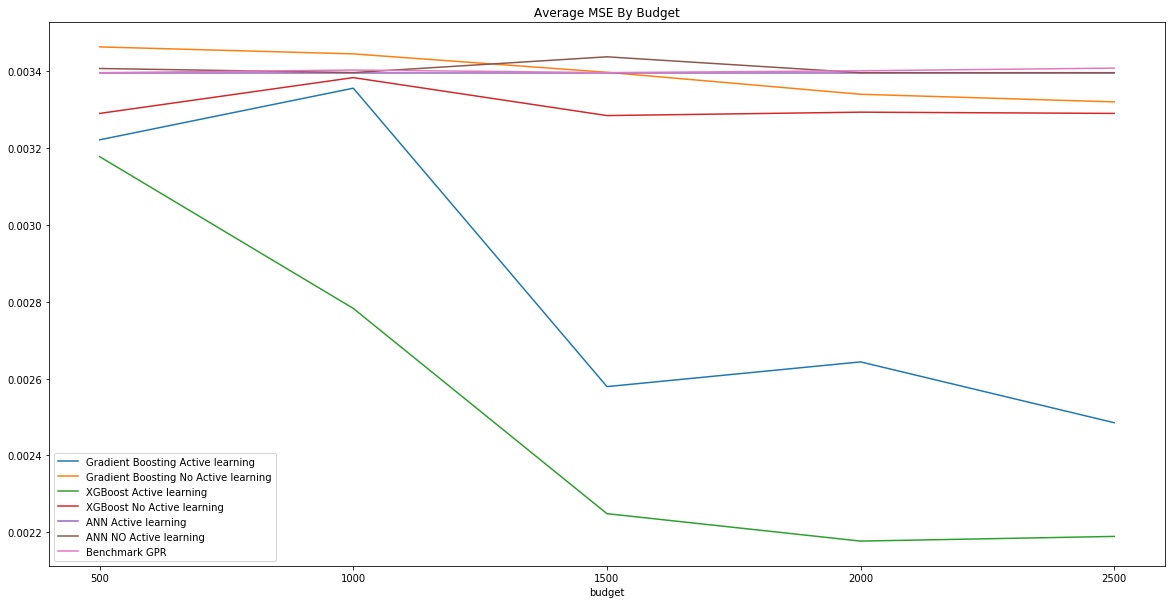

In [53]:
plt.figure(figsize=(25, 10))
mse_ave_his_by_model.plot(figsize=(20, 10), x = 'budget', title = 'Average MSE By Budget', 
                          xticks =np.arange(500,3000,500))    # np.arange(500,3000,500)